In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.wcs import WCS, utils
from astropy.table import Table
from astropy.stats import knuth_bin_width, histogram, bayesian_blocks
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from MUSE_Models import MUSE_3D_OIII, MUSE_3D_residual, PNextractor, PSF_residuals, data_cube_y_x
import corner
%config InlineBackend.figure_format = 'retina'

In [2]:
# functions
# Open Fits file and assign to raw_data
hdulist = fits.open("FCC255_data/FCC255_emission_cube.fits")
hdr = hdulist[0].header
raw_data = hdulist[0].data
raw_data_list = raw_data#[:,382:543]
y_data, x_data, n_data = data_cube_y_x(len(raw_data))
full_wavelength = np.load("exported_data/FCC255/wavelength.npy") #np.exp(hdr['CRVAL3']+np.arange(hdr["NAXIS3"])*hdr['CDELT3'])
wavelength = full_wavelength[382:543]
raw_data_cube = raw_data_list.reshape(y_data, x_data, len(full_wavelength))
raw_data_cube_full = raw_data.reshape(y_data, x_data, len(full_wavelength))

#Read in x and y coordinates
x_y_list = np.load("exported_data/FCC255/sep_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

n_pixels= 11
z = 0.004186
c = 299792458.0
D = 19.7

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

# Retrieve the respective spectra for each PNe source
PNe_spectra = np.array([PNextractor(x, y, n_pixels, raw_data_cube, wave=full_wavelength, dim=2.0) for x,y in zip(x_PNe, y_PNe)])

# create Pandas data frame for values
PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "Total Flux", "Flux error", "V (km/s)", "m 5007", "M 5007", "M 5007 error","A/rN", "rad D"))
PNe_df["PNe number"] = np.arange(0,len(x_PNe)) # PNe numbers
#PNe_df["rad D"] = [np.sqrt((x-x_data/2.)**2 + (y - y_data/2.)**2) for x,y in zip(x_PNe, y_PNe)] # Radial distance, in pixels, from the centre of pointing
# .loc(Row, column name)

# Ra and Dec
#hdu_wcs = fits.open("FCC167_data/FCC167_center_DATACUBE_CLEANED.fits")
#hdr_wcs = hdu_wcs[1].header
#wcs_obj = WCS(hdr_wcs, naxis=2)

#for i in np.arange(0, len(x_PNe)):
#    Ra_Dec = utils.pixel_to_skycoord(x_PNe[i],y_PNe[i], wcs_obj).to_string("hmsdms").split()
#    PNe_df.loc[i,"Ra (J2000)"] = Ra_Dec[0]
#    PNe_df.loc[i,"Dec (J2000)"] = Ra_Dec[1]

# Objective Residual Cube
obj_residual_cube = np.load("exported_data/FCC255/list_of_resids_min_obj.npy")

# Data Residual Cube
residual_cube = np.load("exported_data/FCC255/list_of_resids_min.npy")

def uncertainty_cube_construct(data, x_P, y_P, n_pix):
    data[data == np.inf] = 0.01
    data_shape = data.reshape(y_data, x_data, len(full_wavelength))
    extract_data = np.array([PNextractor(x, y, n_pix, data_shape, wave=full_wavelength, dim=2) for x,y in zip(x_P, y_P)])
    array_to_fill = np.zeros((len(x_P), n_pix*n_pix, len(full_wavelength)))
    for p in np.arange(0, len(x_P)):
        list_of_std = [np.abs(np.std(spec)) for spec in extract_data[p]]
        array_to_fill[p] = [np.repeat(list_of_std[i], len(full_wavelength)) for i in np.arange(0, len(list_of_std))]
  
    return array_to_fill

error_cube = uncertainty_cube_construct(residual_cube, x_PNe, y_PNe, n_pixels)
obj_error_cube = uncertainty_cube_construct(obj_residual_cube, x_PNe, y_PNe, n_pixels)

In [32]:
Gandalf_fit_emission = fits.open("FCC255_data/FCC255_GandALF_fit_emission-002.fits")
G_emission_cube = np.array(Gandalf_fit_emission[0].data).reshape(y_data, x_data, len(full_wavelength))

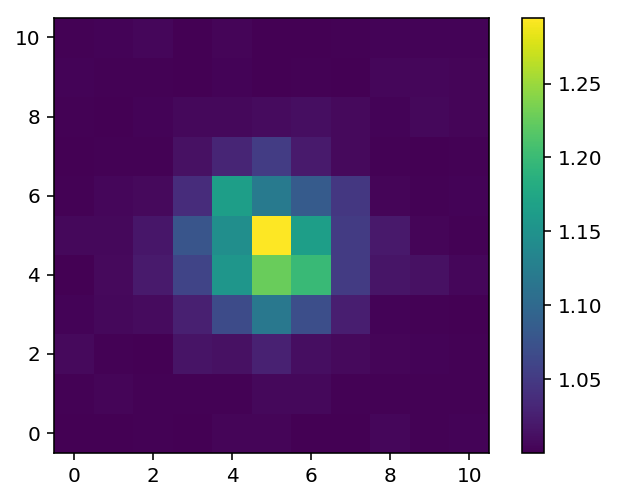

In [21]:
plt.imshow(1/obj_error_cube[0][:,0].reshape(n_pixels,n_pixels), origin="lower")
plt.colorbar()

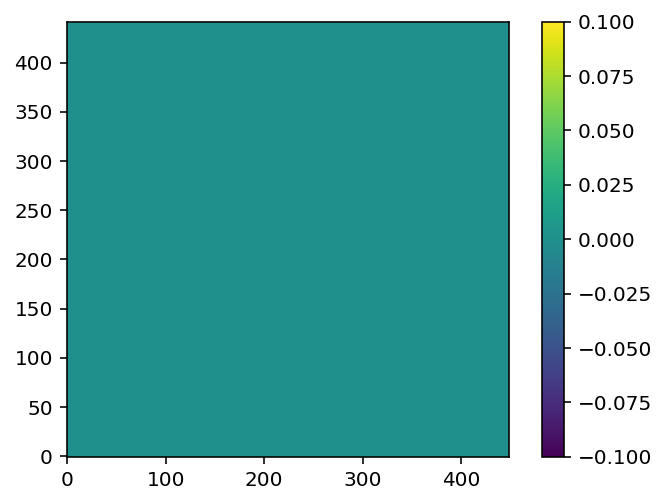

In [23]:
plt.imshow(np.sum(residual_cube,1).reshape(y_data, x_data), origin="lower")
plt.colorbar()

# 3D fitting routine

$$ f(x,y) = A \Big(1+ \frac{(x - x_0)^2 + (y - y_0)^2}{\gamma^2}\Big)^{-\beta} $$

In [3]:
# Parameter setup

PNe_params = Parameters()
PNe_params.add('Amp_2D', value=100., min=0.01)
PNe_params.add('x_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
PNe_params.add('y_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
PNe_params.add("M_FWHM", value=3.878, min=3.4, max=4.2, vary=False)
PNe_params.add("beta", value=5.61, min=2.6, max=3.0, vary=False) #1.46
PNe_params.add("mean", value=5030., min=5000., max=5080.)
PNe_params.add("Gauss_bkg",  value=0.001)
PNe_params.add("Gauss_grad", value=0.001)

FWHM_in_err = 0.2921
beta_in_err = 0.7567

# PNe - norm 0 and 3
#FWHM:      3.758294372477289 +/- 0.03762492436628986 (1.00%)
#Beta:      3.039459541330667 +/- 0.253194413692776 (8.33%)

# Star 0
#FWHM:      3.83168954 +/- 0.05360341 (1.40%) 
#beta:      3.16195655 +/- 0.33747277 (10.67%)

# Star 1
#FWHM:      4.11120256 +/- 0.07236852 (1.76%)
#beta:      5.73194297 +/- 1.42593529 (24.88%)


# MCMC PNe 0
#FWHM:      3.87802385 +/- 9.8073e-04 (0.03%)
#beta:      5.60905018 +/- 0.02430910 (0.43%)


## Fitting routine

27.098127937241998


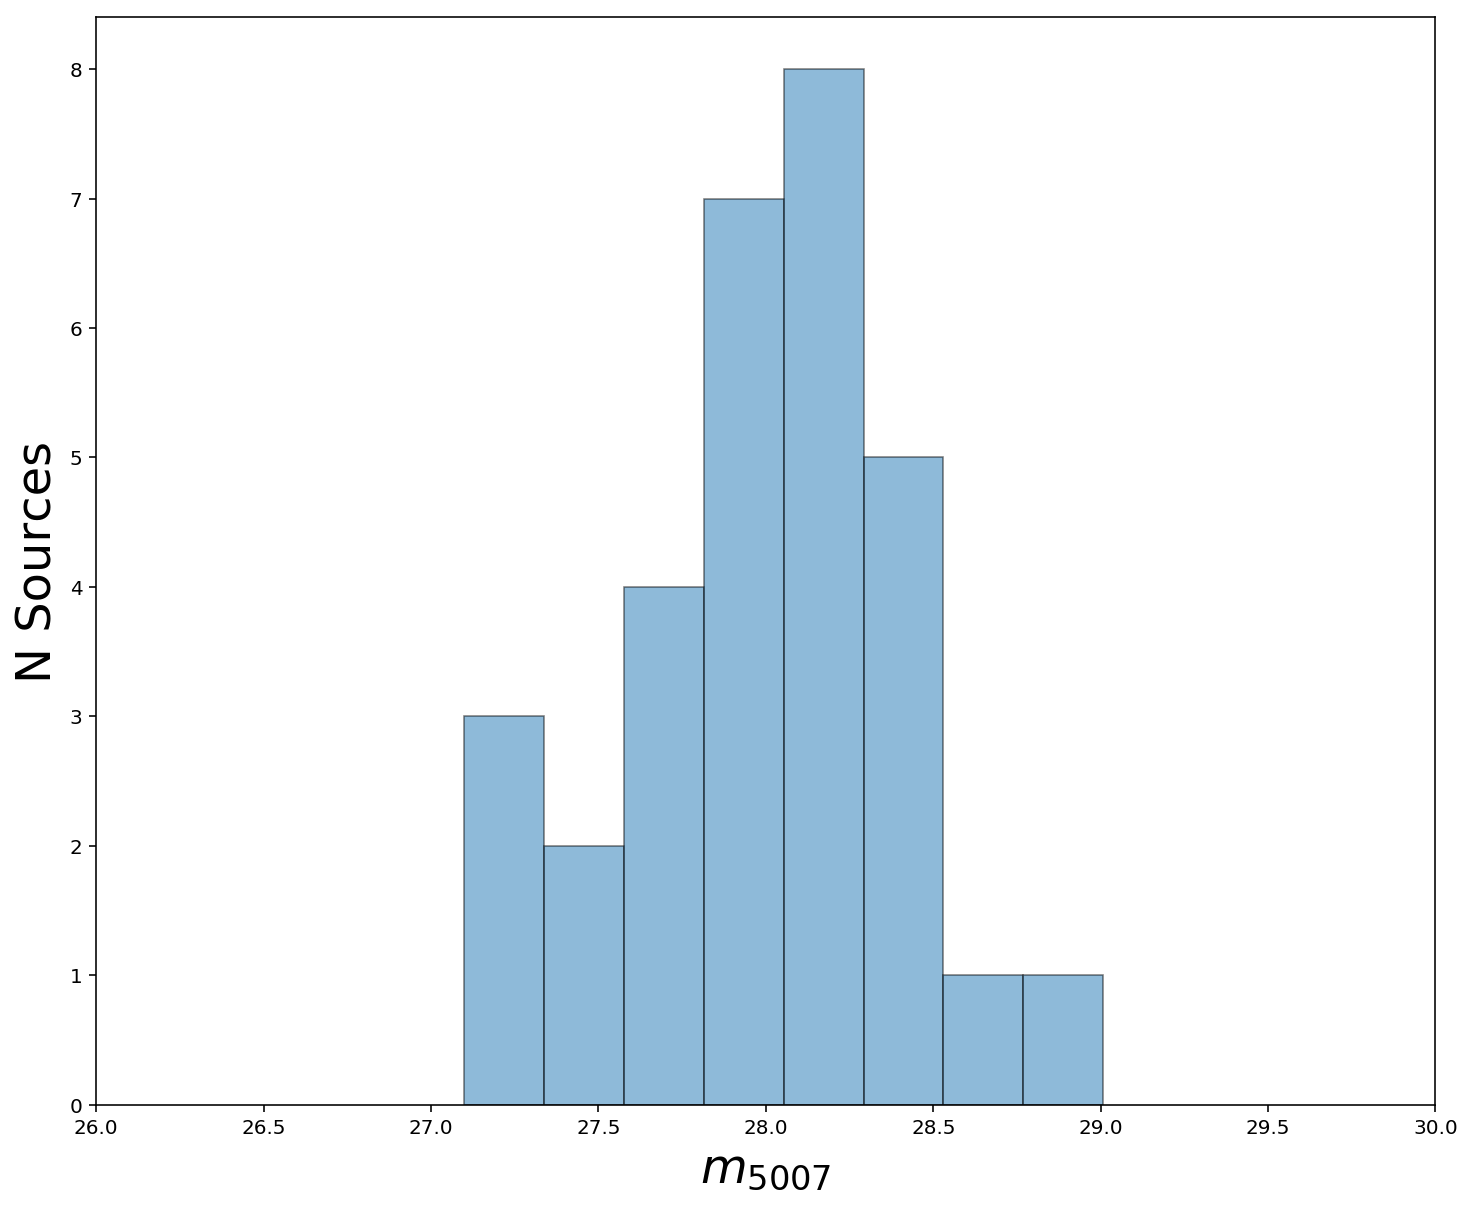

In [4]:
# useful value storage setup
total_Flux = np.zeros(len(x_PNe))
residuals_list = np.zeros(len(x_PNe))
A_OIII_list = np.zeros(len(x_PNe))
F_OIII_xy_list = np.zeros((len(x_PNe), len(PNe_spectra[0])))
M_amp_list = np.zeros(len(x_PNe))
mean_wave_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))

# error lists
moff_A_err = np.zeros(len(x_PNe))
x_0_err = np.zeros(len(x_PNe))
y_0_err = np.zeros(len(x_PNe))
mean_wave_err = np.zeros(len(x_PNe))
Gauss_bkg_err = np.zeros(len(x_PNe))
Gauss_grad_err = np.zeros(len(x_PNe))

FWHM_list = np.zeros(len(x_PNe))
list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))



for PNe_num in np.arange(0, len(x_PNe)):
    useful_stuff = []
    #run minimizer fitting routine
    fit_results = minimize(MUSE_3D_residual, PNe_params, args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num][:,382:543], error_cube[PNe_num][:,382:543], PNe_num, useful_stuff), nan_policy="propagate")
    # Store values in numpy arrays
    PNe_df.loc[PNe_num, "Total Flux"] = np.sum(useful_stuff[1][1]) * 1e-20
    list_of_fit_residuals[PNe_num] = useful_stuff[0]
    A_OIII_list[PNe_num] = useful_stuff[1][0]
    F_OIII_xy_list[PNe_num] = useful_stuff[1][1]
    M_amp_list[PNe_num] = fit_results.params["Amp_2D"]
    list_of_x[PNe_num] = fit_results.params["x_0"]
    list_of_y[PNe_num] = fit_results.params["y_0"]
    mean_wave_list[PNe_num] = fit_results.params["mean"]
    Gauss_bkg[PNe_num] = fit_results.params["Gauss_bkg"]
    Gauss_grad[PNe_num] = fit_results.params["Gauss_grad"]
    #save errors
    moff_A_err[PNe_num] = fit_results.params["Amp_2D"].stderr
    x_0_err[PNe_num] = fit_results.params["x_0"].stderr
    y_0_err[PNe_num] = fit_results.params["y_0"].stderr
    mean_wave_err[PNe_num] = fit_results.params["mean"].stderr
    Gauss_bkg_err[PNe_num] = fit_results.params["Gauss_bkg"].stderr
    Gauss_grad_err[PNe_num] = fit_results.params["Gauss_grad"].stderr

# Signal to noise and Magnitude calculations
list_of_rN = np.array([np.std(PNe_res) for PNe_res in list_of_fit_residuals])
A_by_rN = A_OIII_list / list_of_rN
PNe_df["A/rN"] = A_by_rN

de_z_means = mean_wave_list / (1 + z)

PNe_df["V (km/s)"] = (c * (de_z_means - 5007) / 5007) / 1000

def log_10(x):
    return np.log10(x)

PNe_df["m 5007"] = -2.5 * PNe_df["Total Flux"].apply(log_10) - 13.74
dM =  5. * np.log10(D) + 25   # 31.63
PNe_df["M 5007"] = PNe_df["m 5007"] - dM

#Plotting
plt.figure(1, figsize=(12,10))
bins, bins_cens, other = plt.hist(PNe_df["m 5007"].loc[PNe_df["A/rN"]>2], bins=8, edgecolor="black", linewidth=0.8, label="m 5007 > 2 * A/rN", alpha=0.5)
#plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]<2], edgecolor="black",linewidth=0.8, color="red", alpha=0.5, label="M 5007 <2 * A/rN")
plt.xlim(26.0,30.0)
#plt.title("Absolute Magnitude Histogram", fontsize=24)
plt.xlabel("$m_{5007}$", fontsize=24)
plt.ylabel("N Sources", fontsize=24)
#plt.legend(fontsize=15)
#plt.savefig("Plots/FCC255/M5007 histogram.png")
bins_cens = bins_cens[:-1]
print(PNe_df["m 5007"].min())

In [15]:
np.histogram(PNe_df["m 5007"].loc[PNe_df["A/rN"]>2], bins=8)

(array([3, 2, 4, 7, 8, 5, 1, 1], dtype=int64),
 array([27.09812794, 27.33682954, 27.57553115, 27.81423275, 28.05293435,
        28.29163596, 28.53033756, 28.76903917, 29.00774077]))

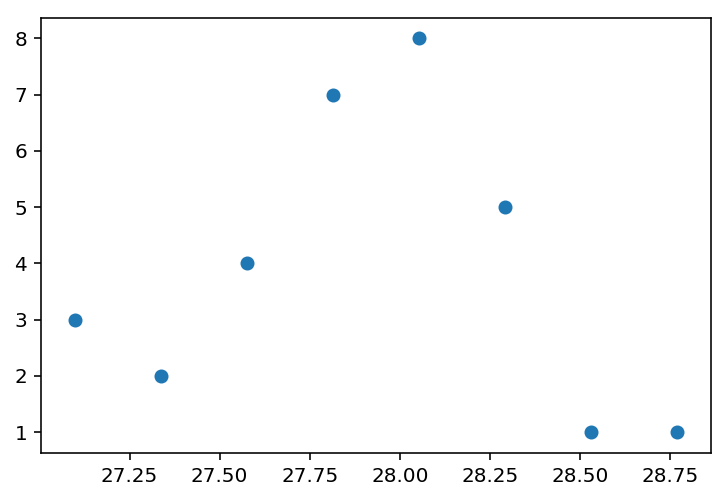

In [17]:
plt.scatter(bins_cens, bins)

In [4]:
PNe_multi_params = Parameters()
# amplitude params
z = 0.00547
PNe_multi_params.add('Amp_2D_OIII_5007', value=200., min=0.01)
PNe_multi_params.add('Amp_2D_OIII_4959', expr="Amp_2D_OIII_5007/3")
PNe_multi_params.add('Amp_2D_Hb', value=1., min=0.01)
PNe_multi_params.add('Amp_2D_Ha', value=1., min=0.01)
PNe_multi_params.add('Amp_2D_NII_1', value=1., min=0.01)
PNe_multi_params.add('Amp_2D_NII_2', value=1., min=0.01)

PNe_multi_params.add('x_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
PNe_multi_params.add('y_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
PNe_multi_params.add("M_FWHM", value=3.75, min=3.4, max=4.2, vary=False)
PNe_multi_params.add("beta", value=3.0, min=2.6, max=3.0, vary=False)

# wavelengths params
PNe_multi_params.add("wave_OIII_5007", value=5030., min=5000., max=5080.)
PNe_multi_params.add("wave_OIII_4959", expr="wave_OIII_5007 - 47.9399")
PNe_multi_params.add("wave_Hb", expr="wave_OIII_5007 - 145.518 * (1+{0})".format(z))
PNe_multi_params.add("wave_Ha", expr="wave_OIII_5007 + 1556.375 * (1+0.00547)")
PNe_multi_params.add("wave_NII_1", expr="wave_OIII_5007 + 1541.621 * (1+0.00547)")
PNe_multi_params.add("wave_NII_2", expr="wave_OIII_5007 + 1577.031 * (1+0.00547)")

PNe_multi_params.add("Gauss_bkg",  value=0.00001)
PNe_multi_params.add("Gauss_grad", value=0.00001)


total_Flux = np.zeros((len(x_PNe),6))
A_OIII_list = np.zeros((len(x_PNe),6))
F_OIII_xy_list = np.zeros((len(x_PNe), 6, len(PNe_spectra[0])))
emission_amp_list = np.zeros((len(x_PNe),6))
model_spectra_list = np.zeros((len(x_PNe), n_pixels*n_pixels, len(full_wavelength)))
mean_wave_list = np.zeros((len(x_PNe),6))
residuals_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(full_wavelength)))

# error lists
moff_A_err = np.zeros(len(x_PNe))
x_0_err = np.zeros(len(x_PNe))
y_0_err = np.zeros(len(x_PNe))
mean_wave_err = np.zeros(len(x_PNe))
Gauss_bkg_err = np.zeros(len(x_PNe))
Gauss_grad_err = np.zeros(len(x_PNe))

FWHM_list = np.zeros(len(x_PNe))
list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))

useful_stuff = []

for PNe_num in np.arange(0,1):# len(x_PNe)):
    multi_fit_results = minimize(MUSE_3D_residual, PNe_multi_params, args=(full_wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, useful_stuff), nan_policy="propagate")
    total_Flux[PNe_num] = np.sum(useful_stuff[1][1],1) * 1e-20
    list_of_fit_residuals[PNe_num] = useful_stuff[0]
    A_OIII_list[PNe_num] = useful_stuff[1][0]
    F_OIII_xy_list[PNe_num] = useful_stuff[1][1]
    model_spectra_list[PNe_num] = useful_stuff[1][3]
    emission_amp_list[PNe_num] = [multi_fit_results.params["Amp_2D_OIII_5007"], multi_fit_results.params["Amp_2D_OIII_4959"], multi_fit_results.params["Amp_2D_Hb"],
                                  multi_fit_results.params["Amp_2D_Ha"], multi_fit_results.params["Amp_2D_NII_1"], multi_fit_results.params["Amp_2D_NII_2"]]    
    mean_wave_list[PNe_num] = [multi_fit_results.params["wave_OIII_5007"], multi_fit_results.params["wave_OIII_4959"], multi_fit_results.params["wave_Hb"],
                               multi_fit_results.params["wave_Ha"], multi_fit_results.params["wave_NII_1"], multi_fit_results.params["wave_NII_2"]]    
    list_of_x[PNe_num] = multi_fit_results.params["x_0"]
    list_of_y[PNe_num] = multi_fit_results.params["y_0"]
    Gauss_bkg[PNe_num] = multi_fit_results.params["Gauss_bkg"]
    Gauss_grad[PNe_num] = multi_fit_results.params["Gauss_grad"]
    #save errors
    #moff_A_err[PNe_num] = multi_fit_results.params["Amp_2D"].stderr
    #x_0_err[PNe_num] = multi_fit_results.params["x_0"].stderr
    #y_0_err[PNe_num] = multi_fit_results.params["y_0"].stderr
    #mean_wave_err[PNe_num] = multi_fit_results.params["mean"].stderr
    #Gauss_bkg_err[PNe_num] = multi_fit_results.params["Gauss_bkg"].stderr
    #Gauss_grad_err[PNe_num] = multi_fit_results.params["Gauss_grad"].stderr


In [5]:
print(total_Flux[0][0])
a = (total_Flux[0][0]/1e-20) / (np.sqrt(2*np.pi) * (2.81 / 2.35482))

m = -2.5 * np.log10(total_Flux[0][0]) - 13.74
dM =  5. * np.log10(D) + 25   # 31.63
M = m - dM
print(m, M, a)

4.4998742933599994e-17
27.126999045818657 -4.345332084989309 1504.3948682581922


In [9]:
F_OIII_xy_list.shape

(31, 6, 121)

In [7]:
report_fit(multi_fit_results)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 311817
    # variables        = 10
    chi-square         = 312657.243
    reduced chi-square = 1.00272683
    Akaike info crit   = 859.113196
    Bayesian info crit = 965.614913
[[Variables]]
    Amp_2D_OIII_5007:  228.204437 +/- 1.97101936 (0.86%) (init = 200)
    Amp_2D_OIII_4959:  76.0681455 +/- 0.65700645 (0.86%) == 'Amp_2D_OIII_5007/3'
    Amp_2D_Hb:         17.6923455 +/- 2.04756461 (11.57%) (init = 1)
    Amp_2D_Ha:         38.5210283 +/- 2.37817738 (6.17%) (init = 1)
    Amp_2D_NII_1:      0.06622983 +/- 2.39081839 (3609.88%) (init = 1)
    Amp_2D_NII_2:      4.30803848 +/- 2.38193078 (55.29%) (init = 1)
    x_0:               4.65390364 +/- 0.02137747 (0.46%) (init = 5.5)
    y_0:               4.95951828 +/- 0.02153607 (0.43%) (init = 5.5)
    M_FWHM:            3.75 (fixed)
    beta:              3 (fixed)
    wave_OIII_5007:    5029.94399 +/- 0.01437794 (0.00%) (init = 

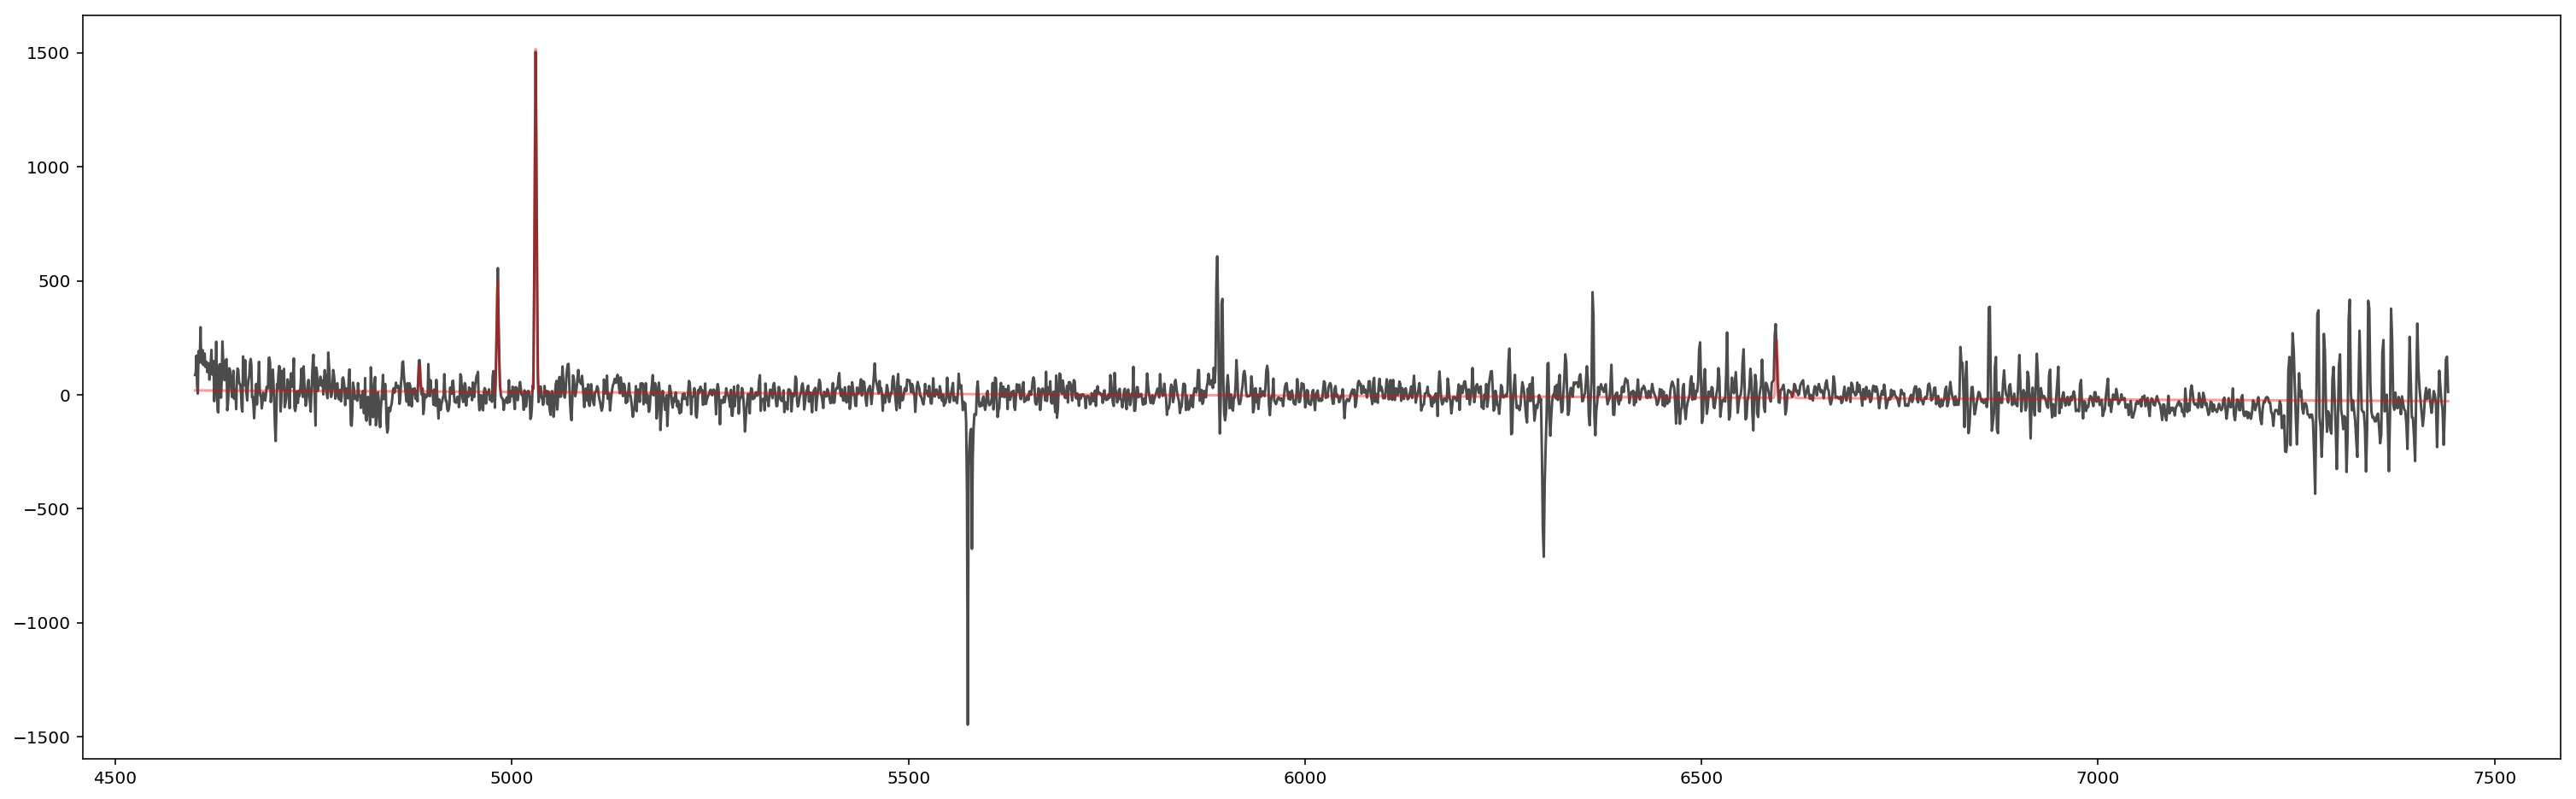

In [8]:

sum_model_spec_ = np.sum(model_spectra_list[0],0)

plt.figure(figsize=(26,8))
plt.plot(full_wavelength, np.sum(PNe_spectra[0],0), alpha=0.7, c="k")

plt.plot(full_wavelength, sum_model_spec_, c="r", alpha=0.4)

In [13]:
PNe_df

,PNe number,Ra (J2000),Dec (J2000),Total Flux,Flux error,V (km/s),m 5007,M 5007,M 5007 error,A/rN,rad D
0,0,NaN,NaN,4.62114e-17,NaN,120.361297,27.098128,-4.374203,NaN,21.496553,NaN
1,1,NaN,NaN,1.53395e-17,NaN,30.709301,28.295469,-3.176862,NaN,7.032561,NaN
2,2,NaN,NaN,1.2691e-17,NaN,69.576430,28.501262,-2.971069,NaN,6.089941,NaN
3,3,NaN,NaN,4.0508e-17,NaN,101.553761,27.241147,-4.231184,NaN,16.801210,NaN
4,4,NaN,NaN,1.65803e-17,NaN,122.841468,28.211020,-3.261311,NaN,6.523583,NaN
5,5,NaN,NaN,1.81368e-17,NaN,118.617417,28.113596,-3.358735,NaN,7.356890,NaN
6,6,NaN,NaN,2.51869e-17,NaN,73.535585,27.757061,-3.715270,NaN,9.281876,NaN
7,7,NaN,NaN,1.36061e-17,NaN,75.594053,28.425664,-3.046667,NaN,4.406103,NaN
8,8,NaN,NaN,7.95983e-18,NaN,125.018284,29.007741,-2.464590,NaN,3.213298,NaN
9,9,NaN,NaN,1.64323e-17,NaN,95.500285,28.220756,-3.251575,NaN,4.500218,NaN


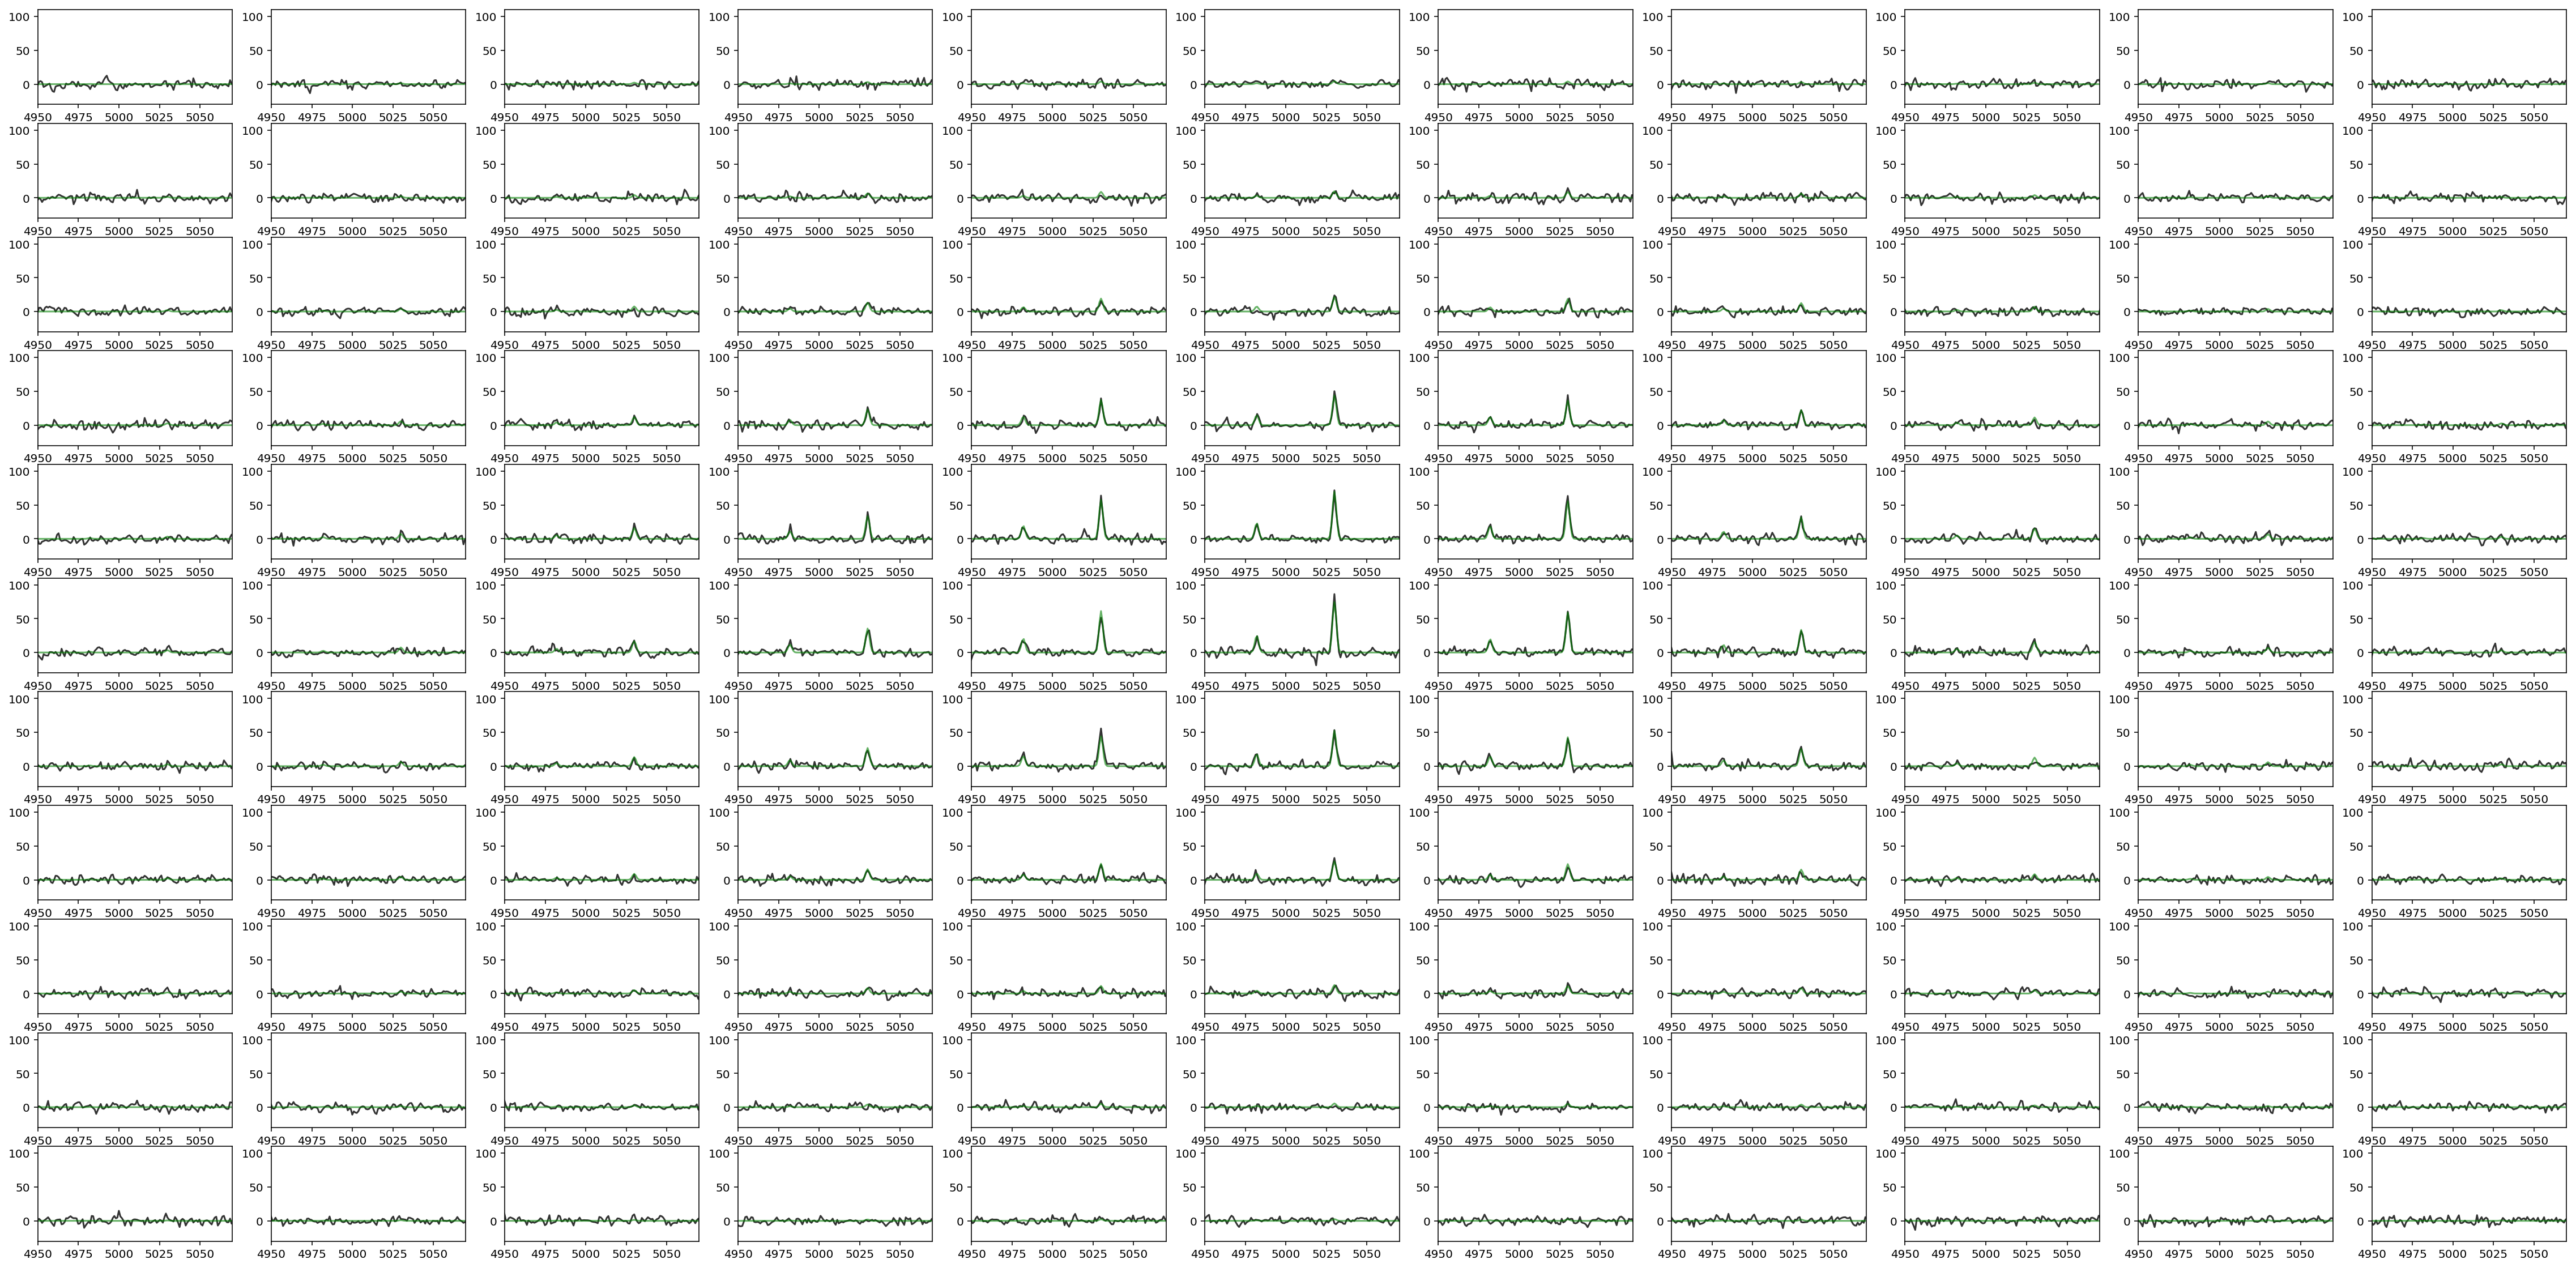

In [19]:
p = 0
PNe_n = PNe_spectra[p]
flux_1D = F_OIII_xy_list[p][0]
A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                 (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

list_of_gauss = [gaussian(full_wavelength, A, mean_wave_list[p][0], 1.19, Gauss_bkg[p], Gauss_grad[p]) for A in A_n]

plt.figure(figsize=(40,20))
for i, spec in enumerate(PNe_n):
    plt.subplot(n_pixels,n_pixels,i+1)
    plt.plot(full_wavelength, spec, c="k", alpha=0.8)
    plt.plot(full_wavelength, list_of_gauss[i], c="g", alpha=0.6)
    plt.ylim(-30, 110)
    plt.xlim(4950,5070)
    

#plt.savefig("Plots/FCC255/PNe_spectra_grid.png")

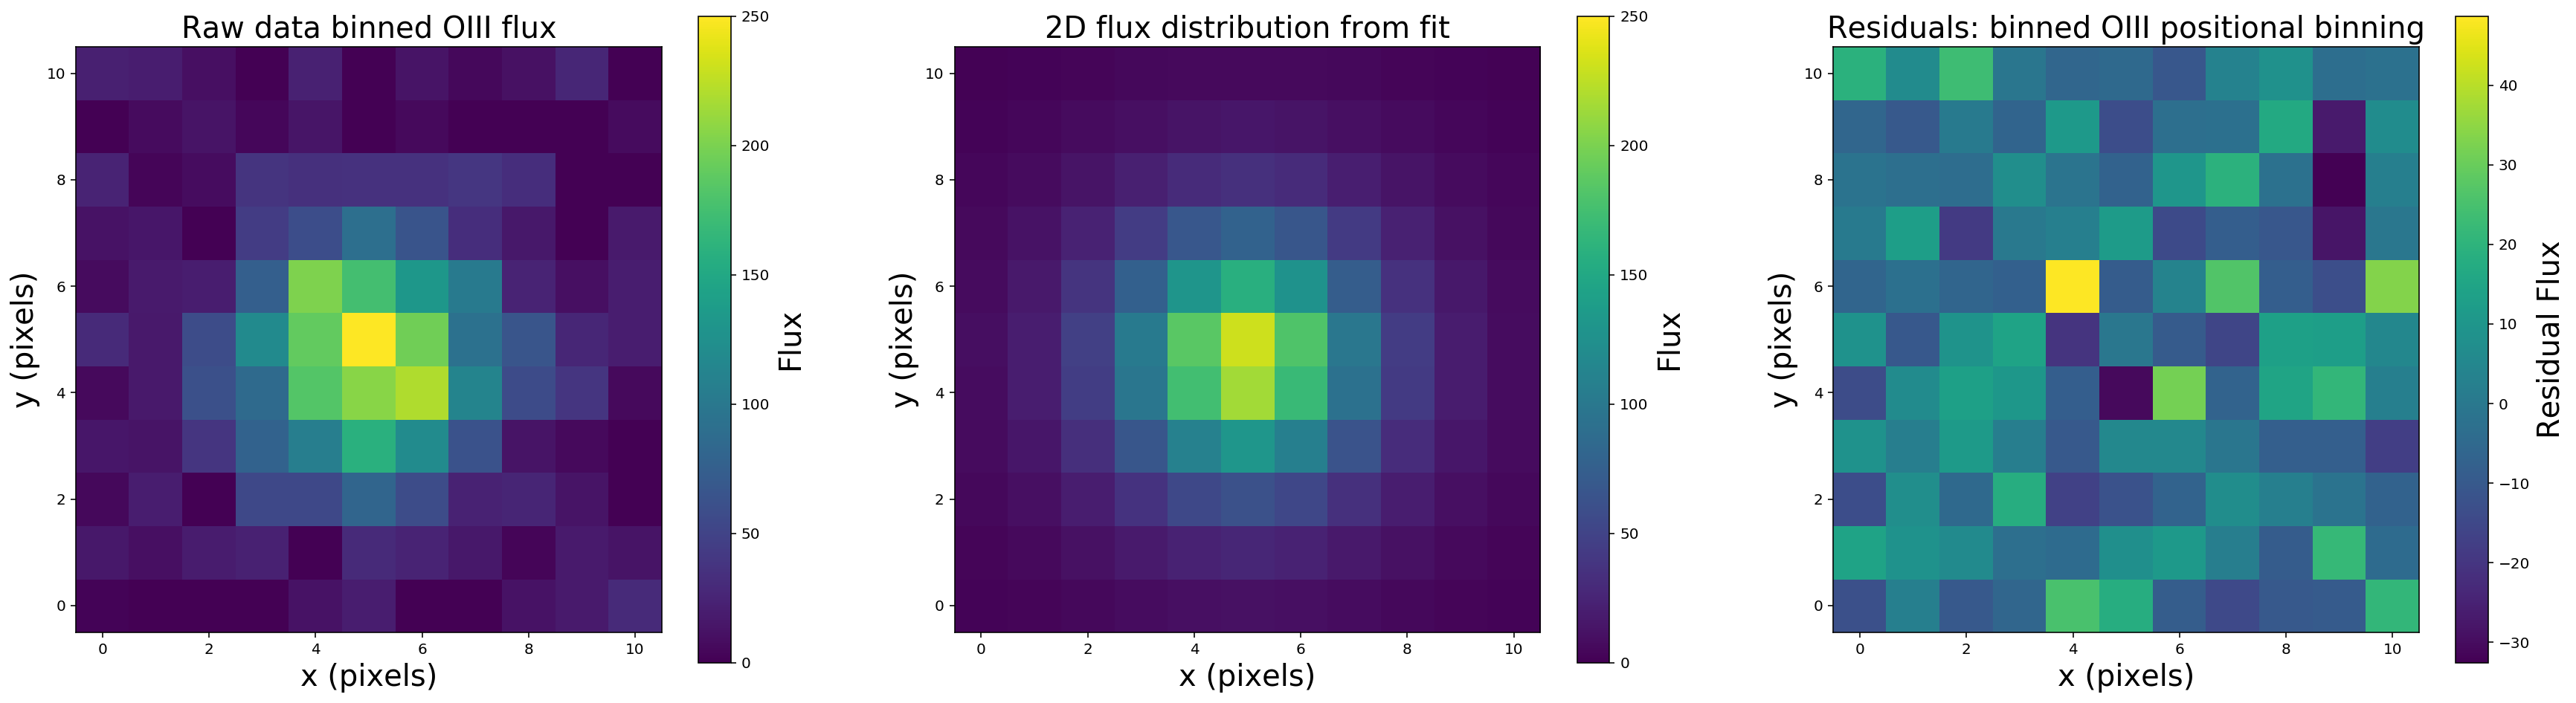

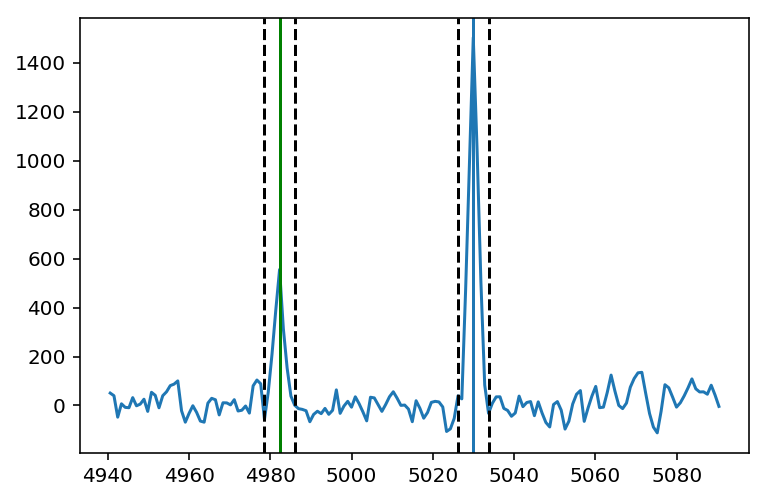

In [29]:
#(p, p+1)
for n in np.arange(p,p+1):#0, len(x_PNe)):
    PNe_n = PNe_spectra[n]
    sum_n = np.sum(PNe_n,0)
    mean_n = mean_wave_list[n]
    peak_0 = min(range(len(wavelength)), key=lambda i: abs(wavelength[i]-mean_wave_list[n]))
    peak_1 = min(range(len(wavelength)), key=lambda i: abs(wavelength[i]-(mean_wave_list[n]-47.93)))
    #if (peak_1 is not peak_0 - 38) or (peak_1 is not peak_0 - 37):
    #    peak_1 = peak_0 - 38
    
    sum_peak_0 = np.sum(PNe_n[:,peak_0-4:peak_0+4],1)
    sum_peak_1 = 0# np.sum(PNe_n[:,peak_1-4:peak_1+4],1)
    combined_peaks = sum_peak_0 + sum_peak_1
    combined_peaks_2D = combined_peaks.reshape(n_pixels, n_pixels)
    
    result_res = list_of_fit_residuals[n]
    result_res_list = result_res.reshape(n_pixels* n_pixels, len(wavelength))
    sum_peak_res_0 = np.sum(result_res_list[:,peak_0-2:peak_0+2],1)
    sum_peak_res_1 = np.sum(result_res_list[:,peak_1-2:peak_1+2],1)
    combined_peaks_res = sum_peak_res_0 + sum_peak_res_1
    combined_peaks_res_2D = combined_peaks_res.reshape(n_pixels, n_pixels)
    
    plt.figure(figsize=(30,8))
    plt.subplot(1,3,1)
    plt.imshow(combined_peaks_2D, origin="lower", vmin=0, vmax=250)
    plt.xlabel("x (pixels)", fontsize=20)
    plt.ylabel("y (pixels)", fontsize=20)
    plt.title("Raw data binned OIII flux", fontsize=20)
    cb = plt.colorbar(label="Flux")
    cb.set_label("Flux", fontsize=20)
    
    plt.subplot(1,3,2)
    plt.imshow(F_OIII_xy_list[n].reshape(n_pixels,n_pixels), origin="lower", vmin=0, vmax=250)
    plt.xlabel("x (pixels)", fontsize=20)
    plt.ylabel("y (pixels)", fontsize=20)
    plt.title("2D flux distribution from fit", fontsize=20)
    cb = plt.colorbar()
    cb.set_label("Flux", fontsize=20)
    
    plt.subplot(1,3,3)
    plt.imshow(combined_peaks_res_2D, origin="lower", vmin=np.min(combined_peaks_res_2D), vmax=np.max(combined_peaks_res_2D))
    plt.xlabel("x (pixels)", fontsize=20)
    plt.ylabel("y (pixels)", fontsize=20)
    plt.title("Residuals: binned OIII positional binning", fontsize=20)
    cb = plt.colorbar()
    cb.set_label("Residual Flux", fontsize=20)
    
    #plt.savefig("Plots/FCC255/data_model_residual_.png")
    
    plt.figure(7)
    plt.plot(wavelength, sum_n)
    plt.axvline(wavelength[peak_0])
    plt.axvline(wavelength[peak_0+4], ls="dashed", c="k")
    plt.axvline(wavelength[peak_0-4], ls="dashed", c="k")
    
    plt.axvline(wavelength[peak_1], c="green")
    plt.axvline(wavelength[peak_1+4], ls="dashed", c="k")
    plt.axvline(wavelength[peak_1-4], ls="dashed", c="k")


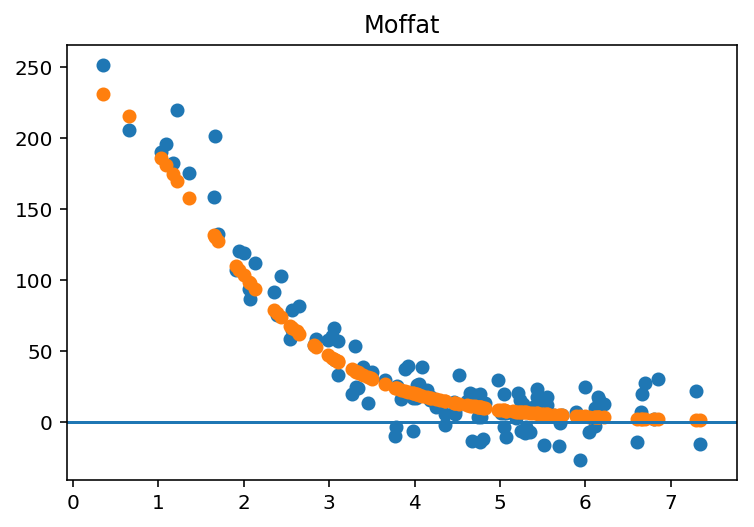

In [30]:
PNe_radials= np.sqrt((x_fit - list_of_x[p])**2 + (y_fit - list_of_y[p])**2)
plt.title("Moffat")
plt.scatter(PNe_radials, combined_peaks_2D)
plt.scatter(PNe_radials, F_OIII_xy_list[p])
#plt.axvline(r)
plt.axhline(0)

In [ ]:
PNe_radials= np.sqrt((x_fit - list_of_x[p])**2 + (y_fit - list_of_y[p])**2)
plt.title("Gaussian")
plt.scatter(PNe_radials, combined_peaks_2D)
plt.scatter(PNe_radials, F_OIII_xy_list[p])
plt.axvline(r)
plt.axhline(0)

In [ ]:
PNe_radials= np.sqrt((x_fit - list_of_x[p])**2 + (y_fit - list_of_y[p])**2)
plt.title("2 Gaussian")
plt.scatter(PNe_radials, combined_peaks_2D)
plt.scatter(PNe_radials, useful_stuff[1][2])
plt.scatter(PNe_radials, useful_stuff[1][3])
plt.scatter(PNe_radials, useful_stuff[1][3]+useful_stuff[1][2])
plt.axvline((11/2.3548))
plt.axhline(0)

In [ ]:
# Residual
result_res = fit_results.residual
result_res_list = result_res.reshape(n_pixels* n_pixels, len(wavelength))
plt.figure(0,figsize=(40,20))
for i, spec in enumerate(result_res_list):
    plt.subplot(n_pixels,n_pixels,i+1)
    plt.plot(wavelength, spec)
    plt.plot(wavelength, list_of_gauss[i])
    plt.ylim(-20,140)

sum_n_res = np.sum(result_res_list,0)
plt.figure(1)
plt.plot(wavelength, sum_n_res)
plt.axvline(wavelength[peak_0])
plt.axvline(wavelength[peak_0+2], ls="dashed", c="k")
plt.axvline(wavelength[peak_0-2], ls="dashed", c="k")

plt.axvline(wavelength[peak_1], c="green")
plt.axvline(wavelength[peak_1+2], ls="dashed", c="k")
plt.axvline(wavelength[peak_1-2], ls="dashed", c="k")

mean_n = mean_wave_list[n]
sum_peak_0 = np.sum(result_res_list[:,peak_0-4:peak_0+4],1)
sum_peak_1 = np.sum(result_res_list[:,peak_1-4:peak_1+4],1)
combined_peaks = sum_peak_0 + sum_peak_1
plt.figure(2)
plt.imshow(combined_peaks.reshape(n_pixels, n_pixels), origin="lower", vmin=-np.max(combined_peaks), vmax=np.max(combined_peaks))
plt.colorbar()

# Completeness

In [5]:
Noise_map = np.abs(np.std(raw_data_cube, axis=2))
#plt.imshow(Noise_map, origin="lower", cmap="CMRmap", vmin=0, vmax=20)

# Setup range of Absolute Magnitudes to be converted to 1D max A values
#Abs_M = bins_cens # np.arange(-4.5,-1.5, 0.5)#bins_cens
#dM = 5. * np.log10(18.7)+25
app_m = bins_cens

total_flux = 10**((app_m + 13.74) / -2.5)
flux = total_flux / 1e-20

def moffat(amplitude, x_0, y_0, FWHM, beta):
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((x_fit - x_0)**2 + (y_fit - y_0)**2) / gamma**2
    return amplitude * (1 + rr_gg)**(-beta)

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                 (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

init_FWHM = PNe_params["M_FWHM"].value
init_beta = PNe_params["beta"].value
sum_init = np.sum(moffat(1, n_pixels/2, n_pixels/2, init_FWHM, init_beta))
input_moff_A = flux / sum_init

# Make moffat models = F_5007 (x,y)
Moffat_models = np.array([moffat(moff_A, n_pixels/2., n_pixels/2., init_FWHM, init_beta) for moff_A in input_moff_A])

# A_5007 (x,y)
Amp_x_y = ((Moffat_models) / (np.sqrt(2*np.pi) * 1.19))

max_1D_A = np.array([np.max(A) for A in Amp_x_y])

N_data = len(np.nonzero(Noise_map)[0])

Noise_mask = Noise_map
Noise_mask_plot = []
ratio_counter = np.zeros(len(app_m))
for i,a in enumerate(max_1D_A):
    Noise_mask[((a / Noise_map) <2.0)] = np.nan
    nan_counter = np.isnan(Noise_mask).sum()

    ratio_counter[i] = (N_data-nan_counter) / N_data
    Noise_mask_plot.append(Noise_mask)
#    plt.figure(figsize=(14,14))
#    plt.title("Absolute Magniude %s" %Abs_M[i])
#    plt.imshow(Noise_mask, origin="lower", vmin=0, vmax=20)
#    cb=plt.colorbar()
#    plt.savefig("Plots/FCC255/completeness/Abs M %s.png" %Abs_M[i])
#
#Noise_mask = Noise_map
#Noise_mask_plot = []
#
#fig, axs = plt.subplots(2,3, figsize=(20, 10))
#axs = axs.ravel()
#for i,a in enumerate(max_1D_A):
#    Noise_mask[((a / Noise_map) <2.0)] = np.nan
#    axs[i].set_title("$M_{5007} = $ %s" %Abs_M[i])
#    ax = axs[i].imshow(Noise_mask, origin="lower", vmin=0, vmax=30)
#
#plt.savefig("Plots/FCC255/completeness/stack.png")



/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less


## PNLF Fitting Routine

In [24]:
PNLF_df = pd.DataFrame(columns=("m 5007", "PNLF", "binned_values"))
PNLF_df["m 5007"] = PNe_df["m 5007"].loc[PNe_df["A/rN"]>2.0]

diff = abs(bins_cens[0]-bins_cens[1]) / 2
bins_cens_left = bins_cens - diff
bins_cens_right = bins_cens + diff

PNLF_df["binned_values"] = np.digitize(PNLF_df["m 5007"], bins=bins_cens)

def PNLF_func(params, data):
    c1 = params["c1"]
    c2 = params["c2"]
    
    # PNLF equation
    PNLF = c1*np.exp(c2*PNLF_df["m 5007"]) * (1-np.exp(3*((PNLF_df["m 5007"].min() - PNLF_df["m 5007"]))))
    PNLF_df["PNLF"] = PNLF
    # Binning of PNLF values
    PNLF_sum_list = np.zeros(len(bins_cens))
    for i in np.arange(1,len(bins_cens)+1):
        PNLF_sum_list[i-1] = np.mean(PNLF_df["PNLF"].loc[PNLF_df["binned_values"]==i])
    # Scale the binned values

    return data - PNLF_sum_list
                
params_PNLF = Parameters()
params_PNLF.add("c1", value=1)
params_PNLF.add("c2", value=0.307, vary=False)

results = minimize(PNLF_func, params_PNLF, args=(bins,), nan_policy="propagate")
report_fit(results)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 8
    # variables        = 1
    chi-square         = 66.1014250
    reduced chi-square = 9.44306071
    Akaike info crit   = 18.8939901
    Bayesian info crit = 18.9734316
[[Variables]]
    c1:  6.9512e-04 +/- 2.1058e-04 (30.29%) (init = 1)
    c2:  0.307 (fixed)


[0.72635169 1.92228935 2.9429042  3.41546623 3.83417785 4.18785955
 4.47495159 5.10738855]


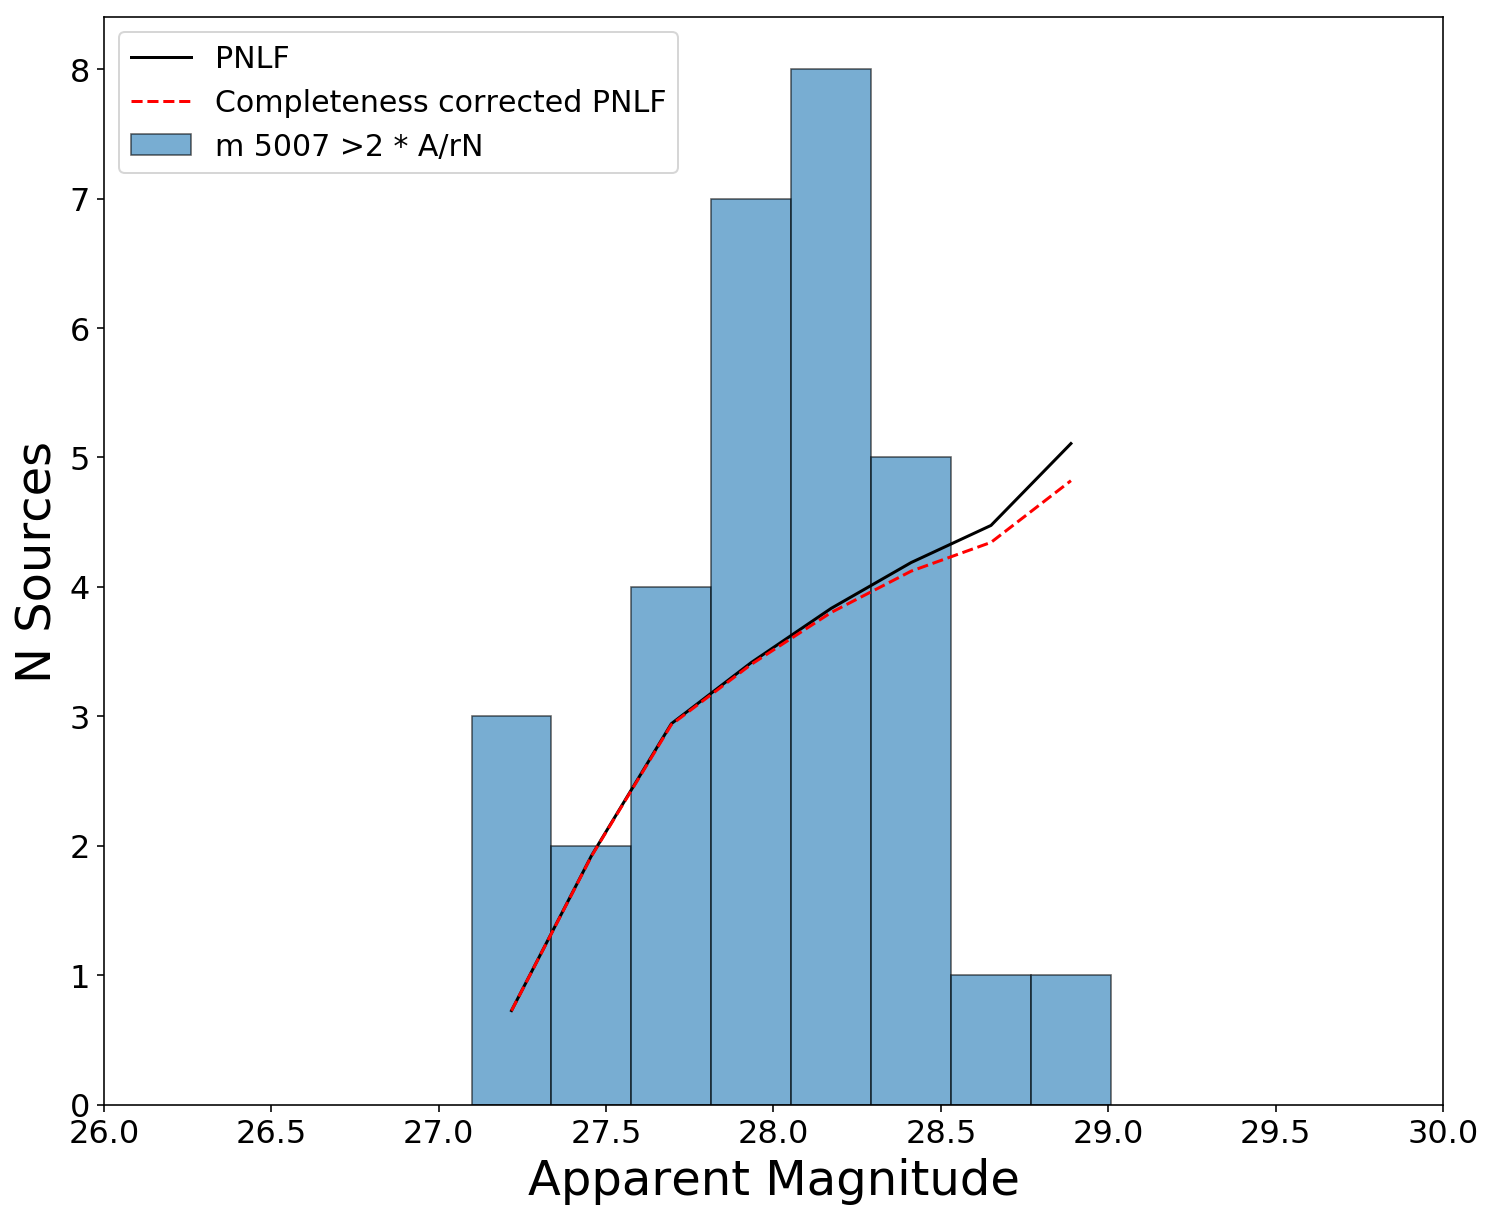

In [25]:
plt.figure(2, figsize=(12,10))
info = plt.hist(PNe_df["m 5007"].loc[PNe_df["A/rN"]>2], bins=len(bins), edgecolor="black", linewidth=0.8, label="m 5007 >2 * A/rN", alpha=0.6)
#plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]<2], bins=4, edgecolor="black",linewidth=0.8, color="red", alpha=0.5, label="M 5007 <2 * A/rN")
ax = plt.gca()
plt.xlim(26.,30.0)
#plt.yticks(np.arange(0,22,2), np.arange(0,22,2))
plt.xlabel("Apparent Magnitude", fontsize=24)
plt.ylabel("N Sources", fontsize=24)
ax.get_yticklabels()
ax.tick_params(labelsize=18)
ax.tick_params(labelsize=16)
#plt.savefig("Plots/FCC255/M5007 histogram.png")

PNLF = results.params["c1"].value*(np.exp(results.params["c2"].value*PNe_df["m 5007"])) * (1-np.exp(3*((PNe_df["m 5007"].min() - PNe_df["m 5007"]))))
#PNLF = (PNLF * results.params["a"]) 
#plt.scatter(PNe_df["M 5007"].loc[PNe_df["M 5007"]>-5], PNLF, c="k")


binned_PNLF = np.zeros(len(bins_cens))
for i in np.arange(1,len(bins_cens)+1):
    binned_PNLF[i-1] = np.mean(PNLF_df["PNLF"].loc[PNLF_df["binned_values"]==i])
    
print(binned_PNLF)
plt.plot(bins_cens_right, (binned_PNLF), color="k", label="PNLF" )
plt.plot(bins_cens_right, (binned_PNLF) * ratio_counter, color="r", ls="--", label="Completeness corrected PNLF" )
plt.legend(fontsize=15)
plt.savefig("Plots/FCC255/PNLF.png")

## Error estimation

In [19]:
def MUSE_3D_err(params, l, x_2D, y_2D, data):
    moffat_amp = params['A_err']
    x_0 = params['x_err']
    y_0 = params['y_err']
    FWHM = params['FWHM_err']
    beta = params["beta_err"]
    mean = params["mean_err"]
    Gauss_FWHM = params["Gauss_FWHM_err"]
    Gauss_bkg = params["Gauss_bkg_err"]
    Gauss_grad = params["Gauss_grad_err"]
    
    #Moffat model
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_2D) - x_0)**2 + (np.array(y_2D) - y_0)**2) / gamma**2
    F_OIII_xy = moffat_amp * (1 + rr_gg)**(-beta)
    
    comb_FWHM = np.sqrt(2.81**2 + Gauss_FWHM**2)
    Gauss_std = comb_FWHM / 2.35482
    
    # Convert Moffat flux to amplitude
    A_OIII_xy = ((F_OIII_xy) / (np.sqrt(2*np.pi) * Gauss_std))
    
    #Construct model gaussian profiles for each amplitude value in cube
    model_spectra = [(Gauss_bkg + (Gauss_grad * l) + np.abs(Amp) * np.exp(- 0.5 * (l - mean)** 2 / Gauss_std**2.) +
             (np.abs(Amp)/3.0) * np.exp(- 0.5 * (l - (mean - 47.9399))** 2 / Gauss_std**2.)) for Amp in A_OIII_xy]
    
    return np.sum(F_OIII_xy * 1e-20)

high_F_list = np.zeros(len(x_PNe))
low_F_list = np.zeros(len(x_PNe))

for num in np.arange(0, len(x_PNe)):
    error_params_add = Parameters()
    error_params_add.add("A_err", value=M_amp_list[num] + moff_A_err[num], vary=False)
    error_params_add.add("x_err", value=list_of_x[num] + x_0_err[num], vary=False)
    error_params_add.add("y_err", value=list_of_y[num] + y_0_err[num], vary=False)
    error_params_add.add("FWHM_err", value=PNe_params["FWHM"].value + FWHM_in_err, vary=False)
    error_params_add.add("beta_err", value=PNe_params["beta"].value + beta_in_err, vary=False)
    error_params_add.add("mean_err", value=mean_wave_list[num] + mean_wave_err[num], vary=False)
    error_params_add.add("Gauss_FWHM_err", value=PNe_params["Gauss_FWHM"].value + 0.0, vary=False)
    error_params_add.add("Gauss_bkg_err", value=Gauss_bkg[num] + Gauss_bkg_err[num], vary=False)
    error_params_add.add("Gauss_grad_err", value=Gauss_grad[num] + Gauss_grad_err[num], vary=False)
    
    error_params_minus = Parameters()
    error_params_minus.add("A_err", value=M_amp_list[num] - moff_A_err[num], vary=False)
    error_params_minus.add("x_err", value=list_of_x[num] - x_0_err[num], vary=False)
    error_params_minus.add("y_err", value=list_of_y[num] - y_0_err[num], vary=False)
    error_params_minus.add("FWHM_err", value=PNe_params["FWHM"].value - FWHM_in_err, vary=False)
    error_params_minus.add("beta_err", value=PNe_params["beta"].value - beta_in_err, vary=False)
    error_params_minus.add("mean_err", value=mean_wave_list[num] - mean_wave_err[num], vary=False)
    error_params_minus.add("Gauss_FWHM_err", value=PNe_params["Gauss_FWHM"].value - 0.0, vary=False)
    error_params_minus.add("Gauss_bkg_err", value=Gauss_bkg[num] - Gauss_bkg_err[num], vary=False)
    error_params_minus.add("Gauss_grad_err", value=Gauss_grad[num] - Gauss_grad_err[num], vary=False)
    
    model_add = MUSE_3D_err(error_params_add, wavelength, x_fit, y_fit, PNe_spectra[num])
    high_F_list[num] = model_add
    model_minus = MUSE_3D_err(error_params_minus, wavelength, x_fit, y_fit, PNe_spectra[num])
    low_F_list[num] = model_minus

delta_F_high = high_F_list - PNe_df["Total Flux"]
delta_F_low = PNe_df["Total Flux"] - low_F_list

PNe_df["Flux error"] = np.median((delta_F_high, delta_F_low))

PNe_df["M 5007 error"] = 1.09 * (PNe_df["Flux error"] / PNe_df["Total Flux"])

# Load in saved data

In [15]:
# Pull out the 1D flux data from 1D fits to do radial comparison
gauss_1D_A = np.load("exported_data/FCC255/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/FCC255/A_rN_cen.npy")

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)

PNe_1D_flux_data = np.array([PNextractor(x, y, n_pixels, Flux_1D_cube, dim=1.0) for x,y in zip(x_PNe,y_PNe)])
PNe_1D_A_rN_data = np.array([PNextractor(x, y, n_pixels, A_rN_plot_shape, dim=1.0) for x,y in zip(x_PNe,y_PNe)])

## Flux and A/rN maps, with circled sources

Text(0,0.5,'y (pixels)')

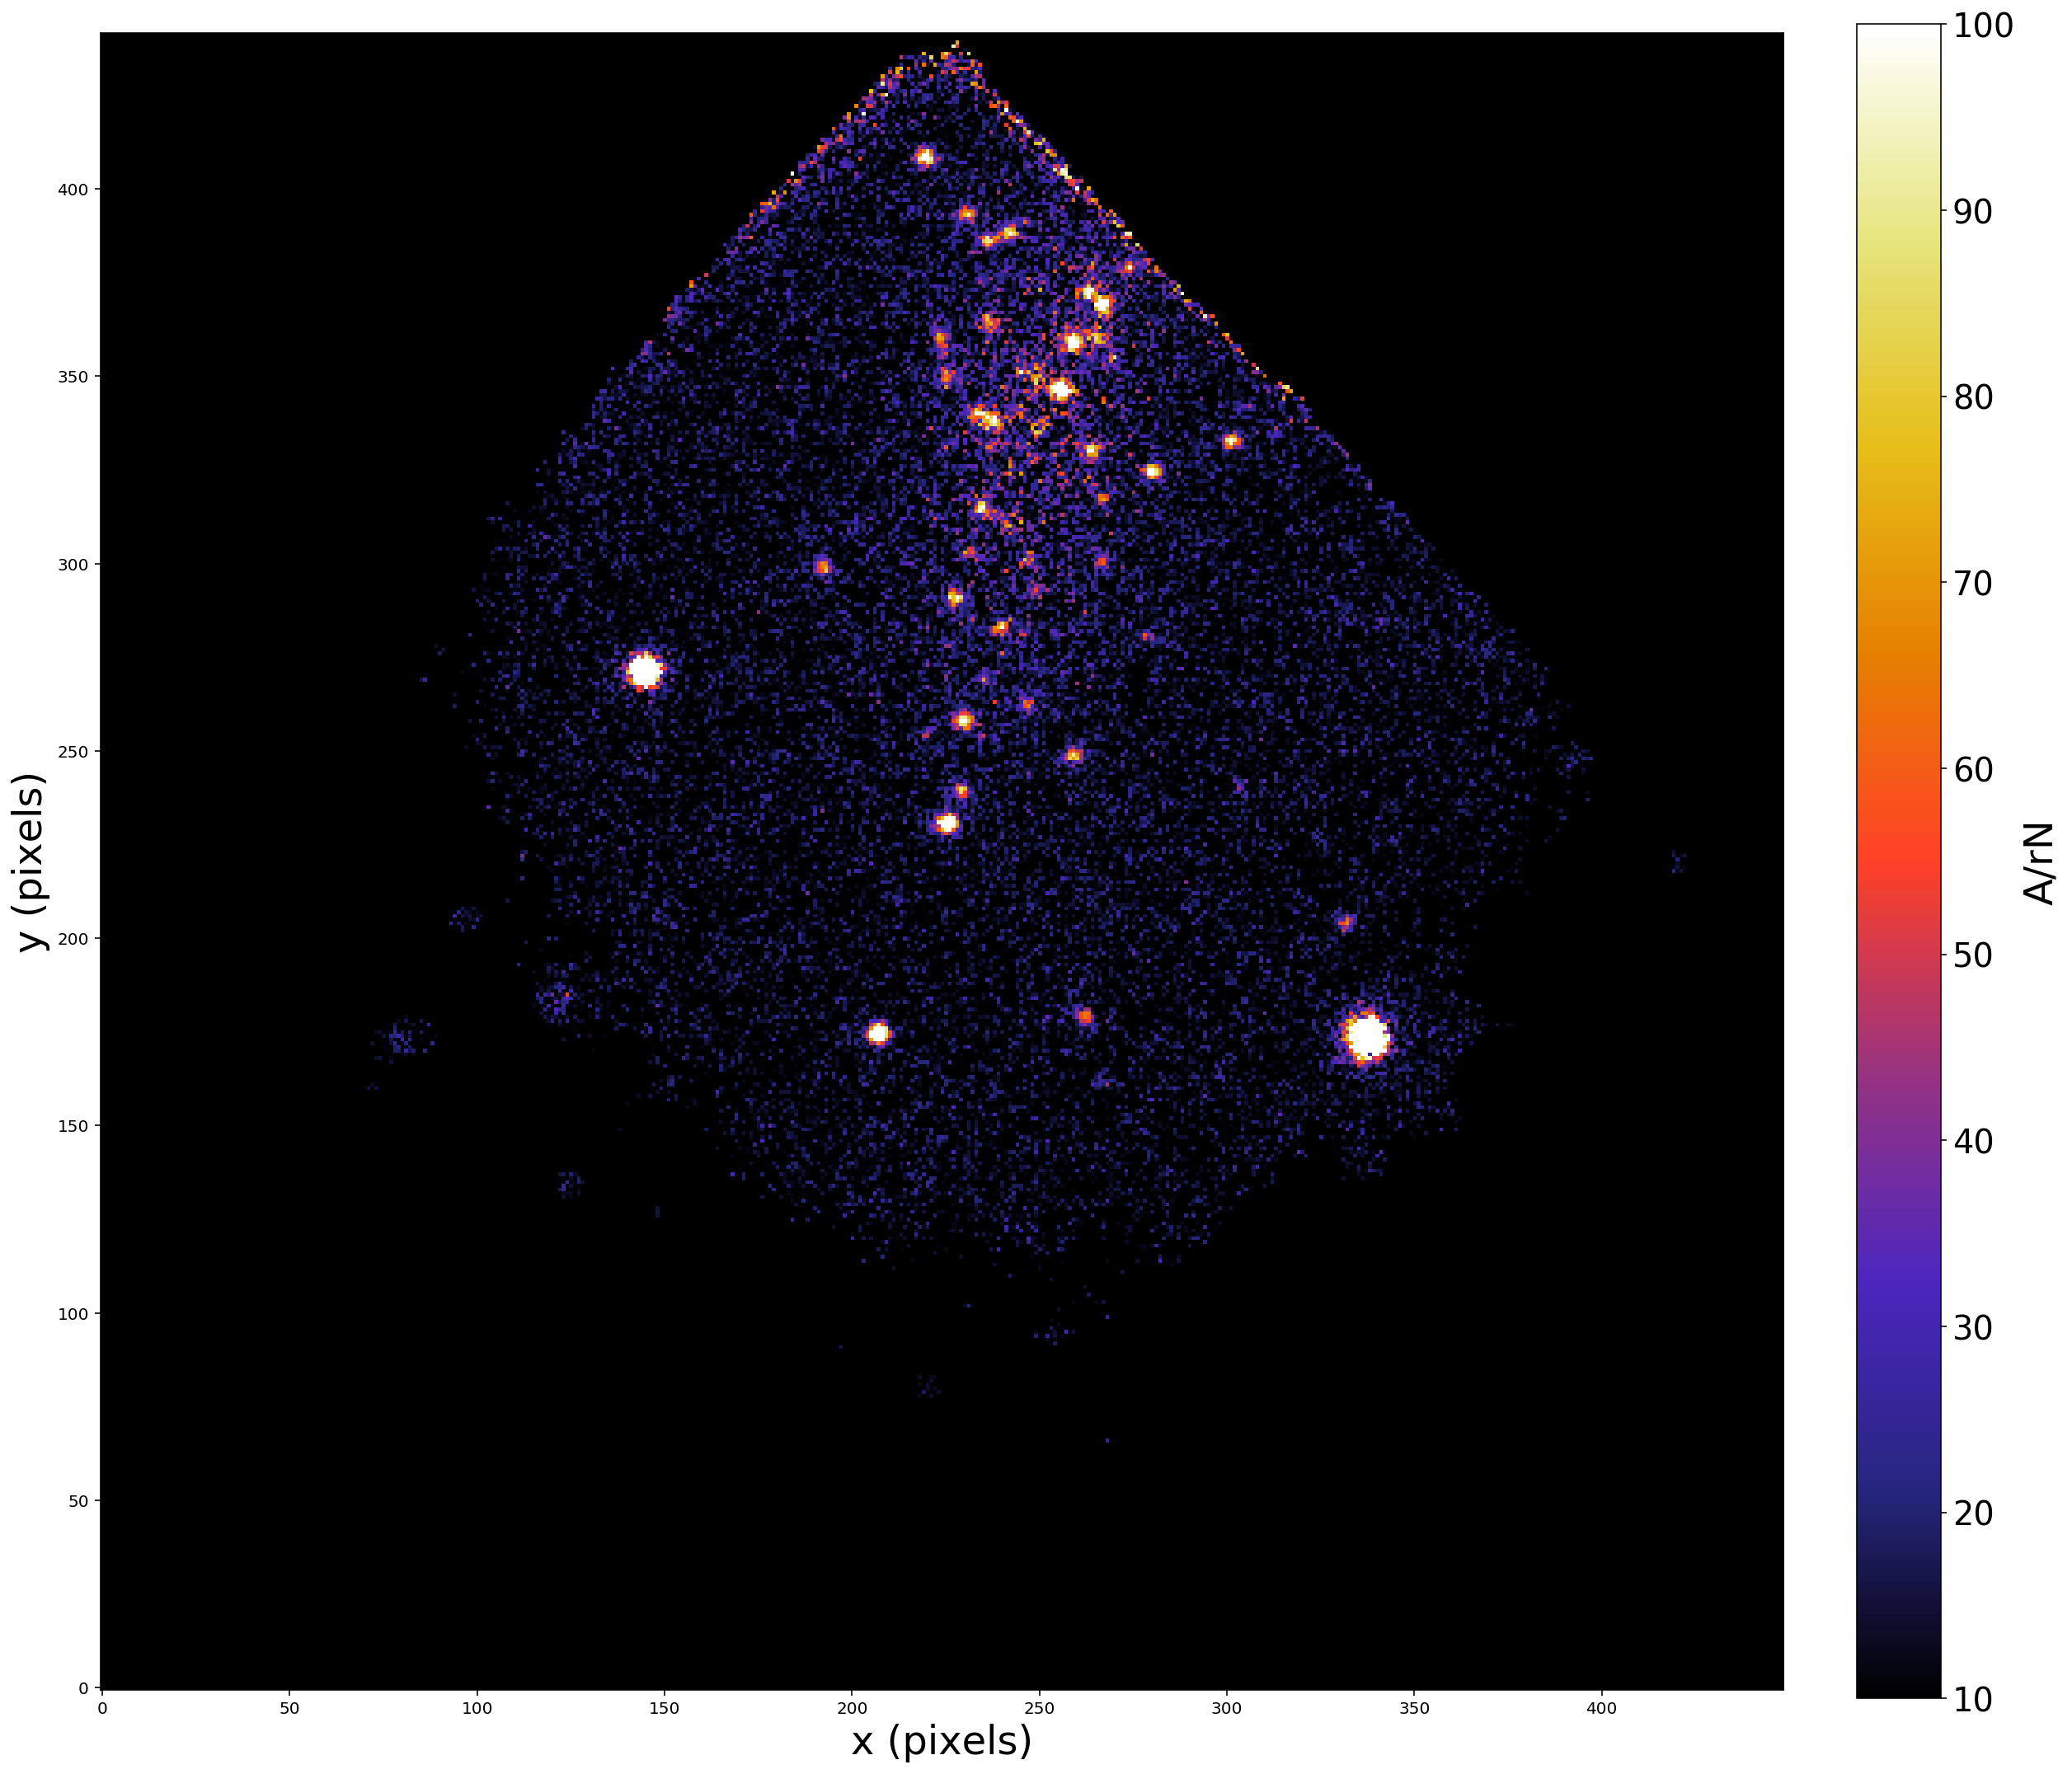

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap", vmin=10, vmax=100)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=24)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=20)
plt.xlabel("x (pixels)", fontsize=24)
plt.ylabel("y (pixels)", fontsize=24)
#circ_r = plt.Circle((x_data/2.,y_data/2.), 80, color="white", fill=False)
#ax.add_artist(circ_r)
#for i, item in enumerate(x_y_list):
#    ax = plt.gca()
#    circ = plt.Circle((item[0],item[1]),6, color="green", fill=False)
#    ax.add_artist(circ)
#    if item[0]<240.:
#        ax.annotate(i, (item[0]+8, item[1]-4), color="white", size=10)
#    else:
#        ax.annotate(i, (item[0]+8, item[1]+2), color="white", size=10)
#
#plt.savefig("Plots/FCC255/ArN circled map.png")

# Velocity vs M_{5007}

(-5, 0)

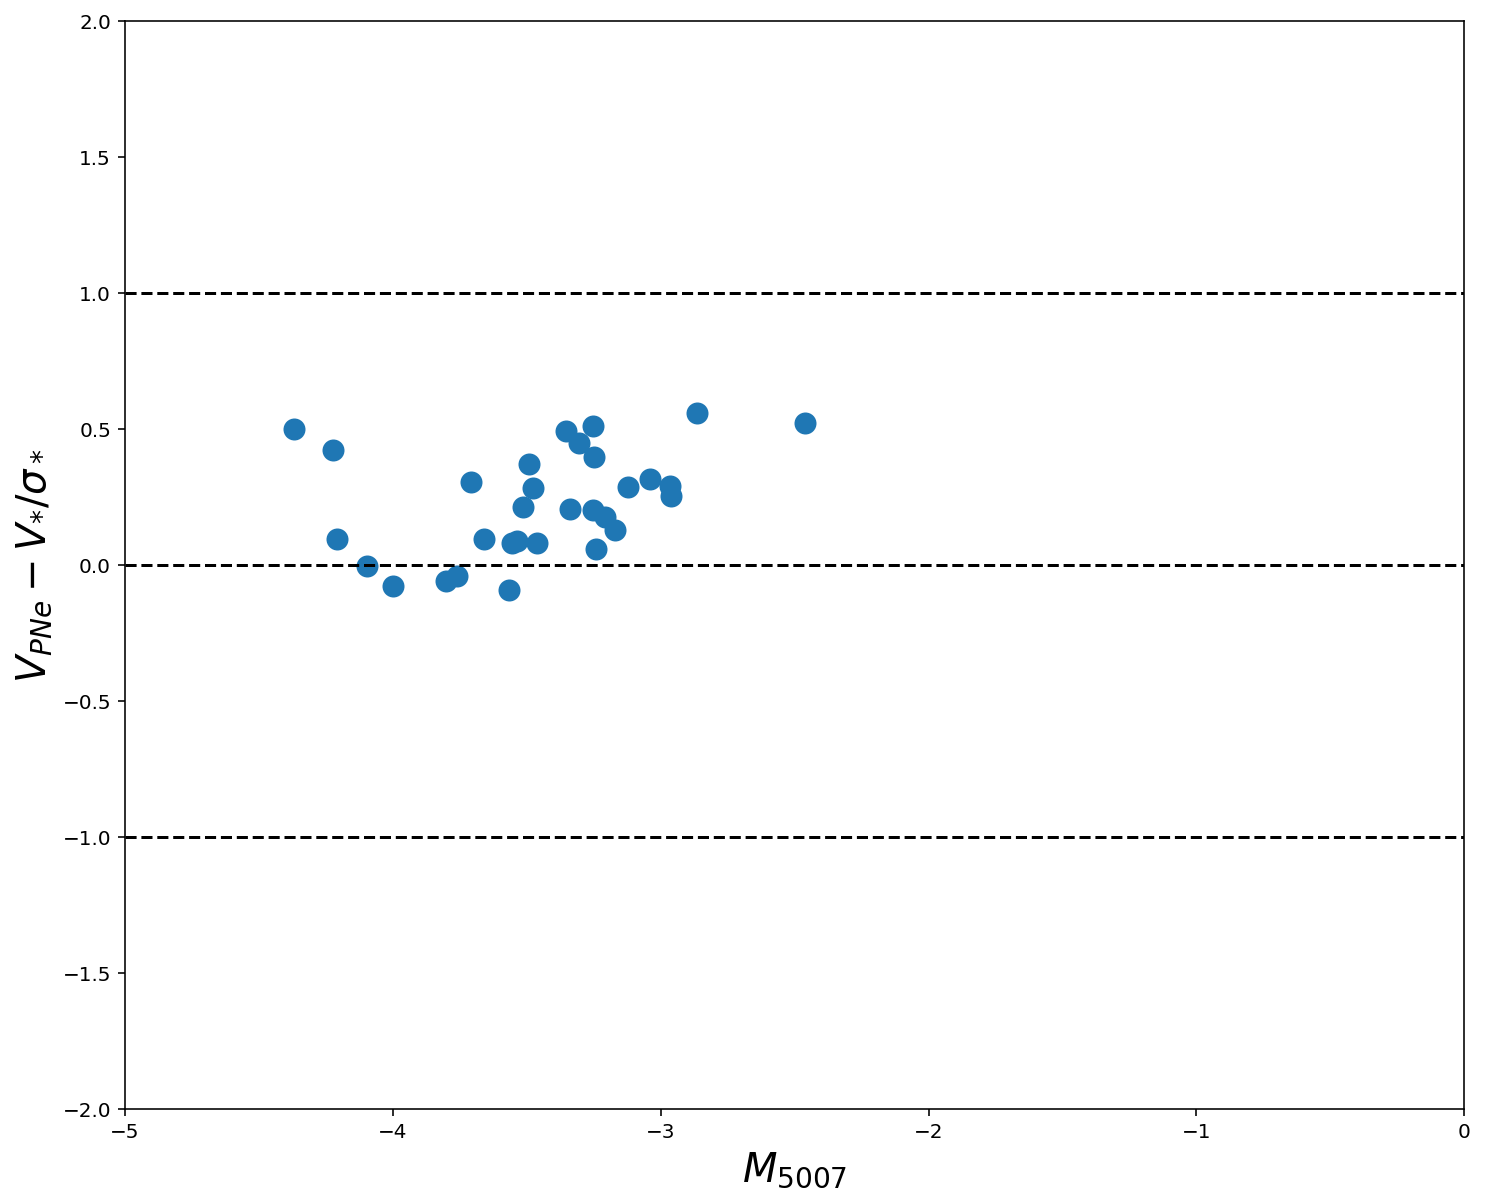

In [40]:
#%% Work on stellar dispersion comparison plot
stellar_vel = 0. # km/s
stellar_dis = 240. # km/s
PNe_vel_ratio = (PNe_df["V (km/s)"].loc[PNe_df["A/rN"]>3.] - stellar_vel)/ stellar_dis

plt.figure(44, figsize=(12,10))
plt.clf()
plt.scatter(PNe_df["M 5007"].loc[PNe_df["A/rN"]>3.], PNe_vel_ratio, s=100)
plt.xlabel("$M_{5007}$", fontsize=20)
plt.ylabel("$V_{PNe} - V_{*} / \sigma_*$", fontsize=20)
plt.axhline(y=1, c="k", ls="dashed")
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-1, c="k", ls="dashed")
plt.ylim(-2,2)
plt.xlim(-5,0)

# MCMC routine


In [147]:
MCMC_df = pd.DataFrame(columns=("PNe number", "Total Flux", "Flux error", "V (km/s)", "m 5007", "M 5007", "M 5007 error","A/rN","stddev", "FWHM", "beta"))
MCMC_df["PNe number"] = np.arange(1,len(x_PNe)+1)

In [ ]:
%%time
# Using MCMC from LMFit, with emcee to fit sources, will need work done before running

def lnprob(params, data, error, num):
    noise = params["f"]
    res = MUSE_3D_residual(params, wavelength, x_fit, y_fit, data, error, num, useful_stuff)
    return -0.5 * np.sum((res / noise)**2 + np.log(2 * np.pi * noise**2))

# Use minimization results from above

MCMC_moff_amp = np.zeros(len(x_PNe))
MCMC_gamma = np.zeros(len(x_PNe))
MCMC_beta = np.zeros(len(x_PNe))
MCMC_params = np.zeros((len(x_PNe),10))


# add a noise parameter and run MCMC for each run from results_for_MCMC
for PNe_num in np.arange(26,27):#, len(x_PNe)):
    useful_stuff = []
    run_mini = minimize(MUSE_3D_residual, params, args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, useful_stuff), nan_policy="propagate")
    mini_result = run_mini
    #add noise parameter
    mini_result.params.add('f', value=1, min=0.001, max=2)
    mini_lnprob = Minimizer(lnprob, mini_result.params, fcn_args=(PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num))
    # Run MCMC routine
    MCMC_results = mini_lnprob.emcee(nwalkers=20, burn=400, steps=1500, thin=8, workers=3, params=mini_result.params)
    # store results
    MCMC_df.loc[PNe_num, "FWHM"] = MCMC_results.params["FWHM"].value
    MCMC_df.loc[PNe_num, "beta"] = MCMC_results.params["beta"].value
    MCMC_df.loc[PNe_num, "stddev"] = MCMC_results.params["Gauss_std"].value
    MCMC_df.loc[PNe_num, "Total Flux"] = useful_stuff[0][0]
    MCMC_df.loc[PNe_num, "V (km/s)"] = (c * (MCMC_results.params["mean"] - 5006.8) / 5006.8) / 1000
    #list_of_best_stddev[PNe_num] = MCMC_results.params["Gauss_std"]
    #list_of_residuals[PNe_num] = useful_stuff[0][1]
    #list_of_A_OIII[PNe_num] = useful_stuff[0][2]
    #list_of_F_OIII_xy[PNe_num] = useful_stuff[0][3]
    #list_of_M_amp[PNe_num] = MCMC_results.params["moffat_amp"]
    #list_of_x[PNe_num] = MCMC_results.params["x_0"]
    #list_of_y[PNe_num] = MCMC_results.params["y_0"]
    #list_of_means[PNe_num] = MCMC_results.params["mean"]
    #list_of_g_bkg[PNe_num] = MCMC_results.params["Gauss_bkg"]
    #list_of_g_grad[PNe_num] = MCMC_results.params["Gauss_grad"]
    #save errors
    #moff_A_err[PNe_num] = results.params["moffat_amp"].stderr
    #x_0_err[PNe_num] = results.params["x_0"].stderr
    #y_0_err[PNe_num] = results.params["y_0"].stderr
    #mean_err[PNe_num] = results.params["mean"].stderr
    #g_bkg_err[PNe_num] = results.params["Gauss_bkg"].stderr
    #g_grad_err[PNe_num] = results.params["Gauss_grad"].stderr
    #h.value += 1
    
A_by_rN = list_of_A_OIII / list_of_residuals
PNe_df["A/rN"] = A_by_rN

def log_10(x):
    return np.log10(x)

MCMC_df["m 5007"] = -2.5 * MCMC_df["Total Flux"].apply(log_10) - 13.74
dM = 31.28 #5. * np.log10(16.4) + 25
MCMC_df["M 5007"] = MCMC_df["m 5007"] - dM

# PSF Fitter - Simultaneous fitter

In [4]:
# Single Run PSF Fitter
#sel_PNe = PNe_df.nsmallest(2, "m 5007").index.values
sel_PNe = [0,6]#,62]#63,26]#[ 28]#, 29]
print(sel_PNe)

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = obj_error_cube[sel_PNe] 
PSF_params = Parameters()

def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("mean_{:03d}".format(n), value=mean, min=5000., max=5070.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.001)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.001)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5030.0)    
    
PSF_params.add('FWHM', value=4.0, min=0.01, max=12., vary=True)
PSF_params.add("beta", value=4.0, min=0.01, max=12., vary=True) 

PSF_results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err), nan_policy="propagate")

print("FWHM: ",PSF_results.params["FWHM"].value, "+/-", PSF_results.params["FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["FWHM"].stderr/PSF_results.params["FWHM"].value)*100) )
print("Beta: ",PSF_results.params["beta"].value, "+/-", PSF_results.params["beta"].stderr, "({:3.2f}%)".format((PSF_results.params["beta"].stderr/PSF_results.params["beta"].value)*100) )
print(report_fit(PSF_results))

[0, 6]
FWHM:  3.8947070712216543 +/- 0.045277899406594886 (1.16%)
Beta:  4.690345316096544 +/- 0.7253132837915953 (15.46%)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 76
    # data points      = 38962
    # variables        = 14
    chi-square         = 763425.310
    reduced chi-square = 19.6011428
    Akaike info crit   = 115948.852
    Bayesian info crit = 116068.837
[[Variables]]
    moffat_amp_000:  226.955512 +/- 2.07205899 (0.91%) (init = 200)
    x_000:           4.67377292 +/- 0.01707693 (0.37%) (init = 5.5)
    y_000:           4.99664089 +/- 0.01724920 (0.35%) (init = 5.5)
    mean_000:        5029.96043 +/- 0.00936864 (0.00%) (init = 5030)
    gauss_bkg_000:   6.6369e-04 +/- 5.6863e-04 (85.68%) (init = 0.001)
    gauss_grad_000: -3.23169997 +/- 2.85176631 (88.24%) (init = 0.001)
    moffat_amp_001:  121.165761 +/- 2.32428849 (1.92%) (init = 200)
    x_001:           5.05519214 +/- 0.04913695 (0.97%) (init = 5.5)
    y_001:           4.768578

# PSF fitting evaluation over individual fittings

In [45]:
num_psf = len(x_PNe)
n_brightest = PNe_df.nlargest(num_psf, "A/rN").index.values
fitted_FWHM = np.zeros(num_psf)
fitted_beta = np.zeros(num_psf)
rad_sel = np.zeros(num_psf)
fitted_G_FWHM = np.zeros(num_psf)

#params = Parameters()
def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("mean_{:03d}".format(n), value=mean, min=4990., max=5060.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.001)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.00001)


for i in np.arange(0, num_psf):
    sel_PNe = [n_brightest[i]]
    selected_PNe = PNe_spectra[sel_PNe]
    selected_PNe_err = obj_error_cube[sel_PNe]
    PSF_params = Parameters()
    model_params(p=PSF_params, n=0, amp=100.0, mean=5030.0)
    PSF_params.add('FWHM', value=2.0, min=0.001, max=8., vary=True)
    PSF_params.add("beta", value=4.0, min=0.001, max=8., vary=True) 
    PSF_params.add("Gauss_FWHM", value=0.0001, min=0.0000001, max=5.0, vary=False)
    rad_sel[i] = PNe_df.iloc[sel_PNe]["rad D"]
    results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, [1.]), nan_policy="propagate")
    fitted_FWHM[i] = results.params["FWHM"].value
    fitted_beta[i] = results.params["beta"].value
    fitted_G_FWHM[i] = results.params["Gauss_FWHM"].value
    


In [ ]:
def straight_res(params, x, data):
    m = params["m"]
    c = params["c"]
    y = m*x + c
    return data - y

straight_params = Parameters()
straight_params.add("m", value=0.1)
straight_params.add("c", value=0.1)

straight_results = minimize(straight_res, straight_params, args=(rad_sel, fitted_beta))
m = straight_results.params["m"].value
c = straight_results.params["c"].value
report_fit(straight_results)

NameError: name 'm' is not defined

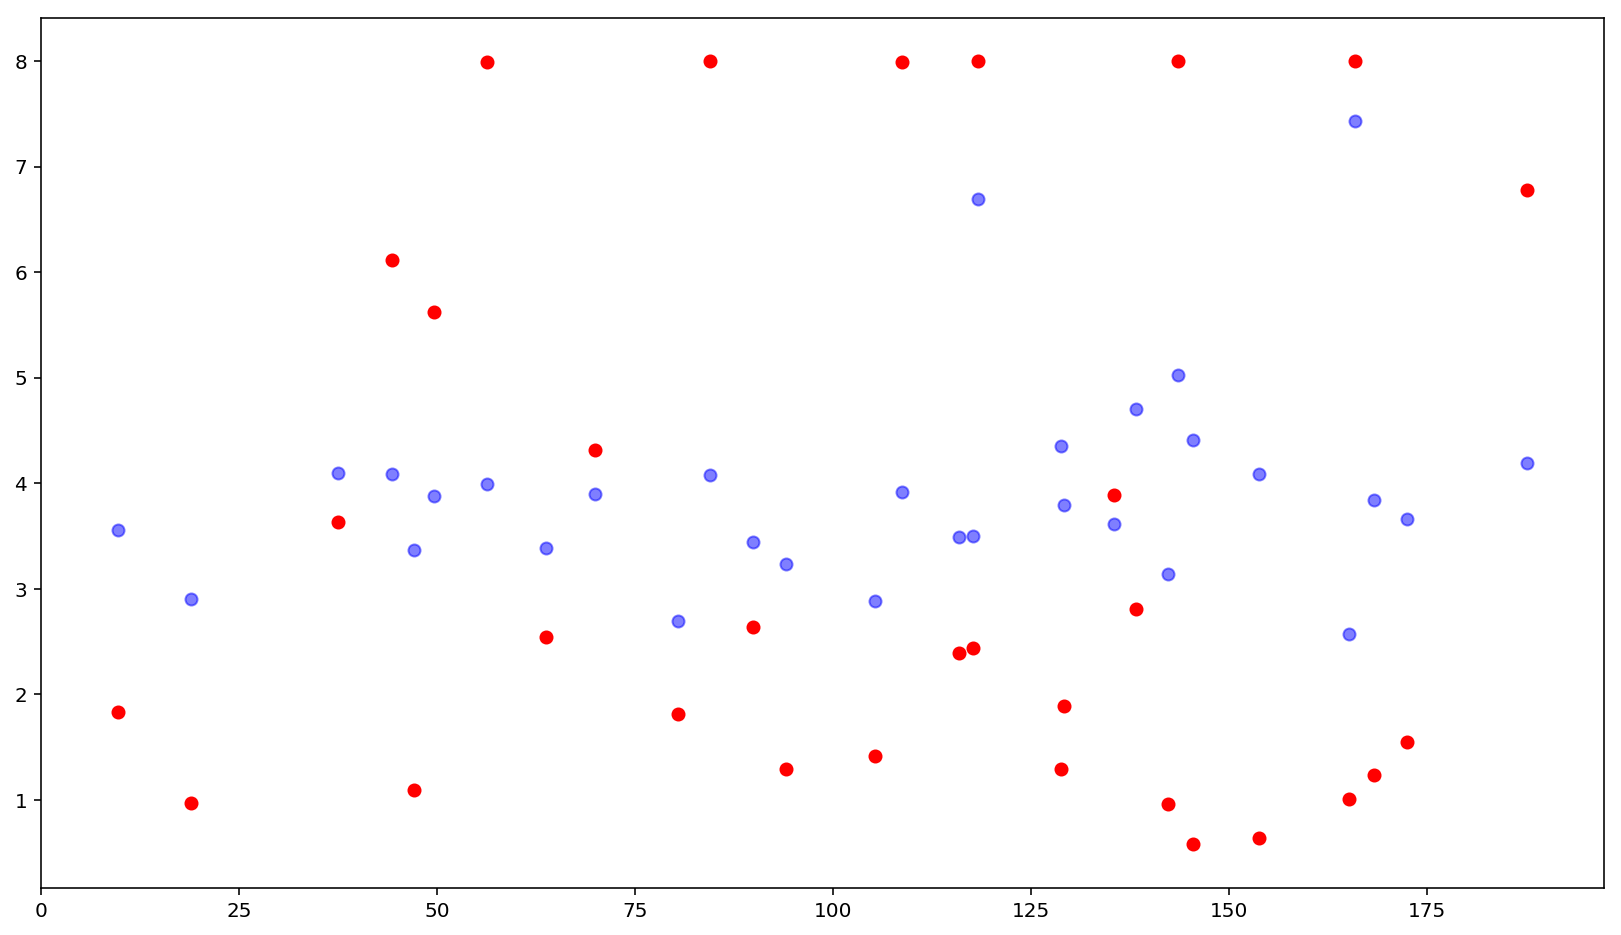

In [46]:
plt.figure(figsize=(14,8))
plt.scatter(rad_sel, fitted_FWHM, label="FWHM", c="blue", alpha=0.5)
plt.scatter(rad_sel, fitted_beta, label="beta", c="red")
plt.plot(rad_sel, (m*rad_sel + c), label="Best beta fit", c="r")
#plt.scatter(rad_sel, fitted_G_FWHM, label="G_FWHM", c="k" )
plt.xlabel("Radial Distance from centre (pixels)", fontsize=20)
plt.ylabel("FWHM (Blue) and Beta (Red)", fontsize=20)
plt.ylim(-0.1,8.1)
plt.grid()

plt.axhline(np.median(fitted_FWHM[:50]), label="FWHM median", ls="dashed", c="blue")
plt.axhline(np.median(fitted_beta[:50]), label="Beta median", ls="dashed", c="red")
#plt.axhline(np.median(fitted_G_FWHM), label="G_FWHM median", ls="dashed", c="k")

print(np.median(fitted_beta[:20]))
print(np.median(fitted_FWHM[:20]))
plt.legend()
plt.savefig("Plots/FCC255/radial_FWHM_beta.png")

# PSF Fitting - Evaluation with differing number of simultaneous PNe fitted

In [47]:
num_psf=10
fitted_FWHM = np.zeros(num_psf)
fitted_beta = np.zeros(num_psf)
A_rN_total = np.zeros(num_psf)
fitted_G_FWHM = np.zeros(num_psf)
fitted_moff_amp = [[]]*num_psf
fitted_x = [[]]*num_psf
fitted_y = [[]]*num_psf

#params = Parameters()
def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("mean_{:03d}".format(n), value=mean, min=5000., max=5070.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.01)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.01)
    
for j in np.arange(0, num_psf):
    sel_PNe = PNe_df.nlargest(j+1, "A/rN").index.values
    selected_PNe = PNe_spectra[sel_PNe]
    selected_PNe_err = obj_error_cube[sel_PNe]
    PSF_params = Parameters()
    for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5030.0)
    PSF_params.add('FWHM', value=2.0, min=0.01, max=12., vary=True)
    PSF_params.add("beta", value=1.0, min=0.01, max=12., vary=True) 
    PSF_params.add("Gauss_FWHM", value=0.0001, min=0.00001, max=3.0, vary=False)
    A_rN_total[j] = np.sqrt(np.sum(PNe_df.iloc[sel_PNe]["A/rN"]**2.))
    A_rN_of_PNe = np.ones(len(sel_PNe))#PNe_df.iloc[sel_PNe]["A/rN"].values
    results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, A_rN_of_PNe), nan_policy="propagate")#, method="differential_evolution")
    fitted_FWHM[j] = results.params["FWHM"].value
    fitted_beta[j] = results.params["beta"].value
    fitted_G_FWHM[j] = results.params["Gauss_FWHM"].value
    #for k in np.arange(0, len(sel_PNe)):
    #    fitted_moff_amp.append(results.params["moffat_amp_{:03d}".format(k)].value)
    #    fitted_x.append(results.params["x_{:03d}".format(k)].value)
    #    fitted_y.append(results.params["y_{:03d}".format(k)].value)

    

3.7517099661277378
2.485676160679091


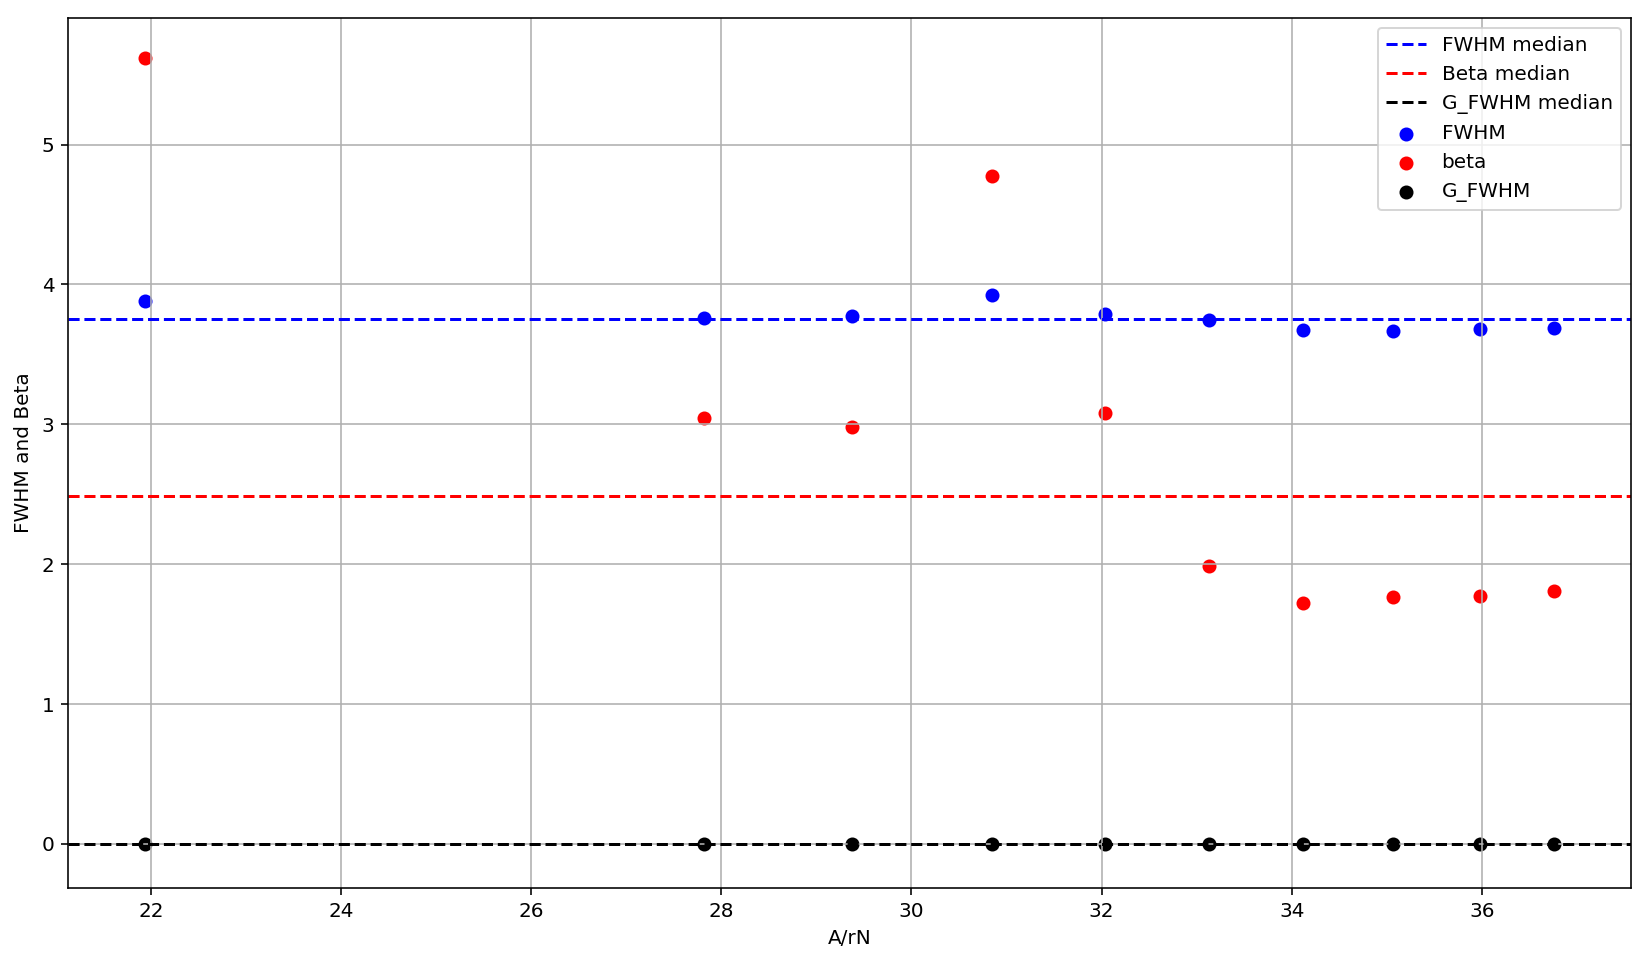

In [48]:
plt.figure(figsize=(14,8))
plt.scatter(A_rN_total, fitted_FWHM, label="FWHM", c="blue")
plt.scatter(A_rN_total, fitted_beta, label="beta", c="red")
plt.scatter(A_rN_total, fitted_G_FWHM, label="G_FWHM", c="k" )
plt.xlabel("A/rN")
plt.ylabel("FWHM and Beta")
plt.grid()

plt.axhline(np.median(fitted_FWHM[:]), label="FWHM median", ls="dashed", c="blue")
plt.axhline(np.median(fitted_beta[:]), label="Beta median", ls="dashed", c="red")
plt.axhline(np.median(fitted_G_FWHM[:]), label="G_FWHM median", ls="dashed", c="k")

print(np.median(fitted_FWHM[:]))
print(np.median(fitted_beta[:]))
      
plt.legend()
#plt.savefig("Plots/FCC255/PSF_A_rN_FWHM_beta.png")

# MCMC PSF fitter

In [4]:
# MCMC
sel_PNe = [0]# PNe_df.nlargest(1, "A/rN").index.values

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = obj_error_cube[sel_PNe] 

PSF_params = Parameters()
def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("mean_{:03d}".format(n), value=mean, min=mean-40., max=mean+40.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.001)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.001)

for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=100.0, mean=5030.0)   
    
PSF_params.add('FWHM', value=4.0, min=0.01, max=12., vary=True)
PSF_params.add("beta", value=4.0, min=0.01, max=12., vary=True) 

def lnprob(p, data, error):
    noise = p["f"]
    res = PSF_residuals(p, wavelength, x_fit, y_fit, data, error)
    return -0.5 * np.sum((res / noise)**2 + np.log(2 * np.pi * noise**2))

# add a noise parameter and run MCMC for each run from results_for_MCMC
run_mini = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err), nan_policy="propagate")
print("Initial fit complete.")
#add noise parameter
run_mini.params.add('f', value=1., min=0.001, max=2.)
print("Nuisance Parameter added.")
mini_lnprob = Minimizer(lnprob, run_mini.params, fcn_args=(selected_PNe, selected_PNe_err))
print("Minimizer ready.")
# Run MCMC routine
print("All aboard the MCMC train.")
MCMC_results = mini_lnprob.emcee(nwalkers=50, burn=100, steps=1000, thin=20, is_weighted=True, params=run_mini.params) #workers=6,

print("FWHM: " , MCMC_results.params["FWHM"].value, MCMC_results.params["FWHM"].stderr)
print("Beta: " , MCMC_results.params["beta"].value, MCMC_results.params["beta"].stderr)

Initial fit complete.
Nuisance Parameter added.
Minimizer ready.
All aboard the MCMC train.
FWHM:  3.899332294172699 0.19629744176732822
Beta:  6.64241082035203 1.9344486606733895


In [11]:
report_fit(MCMC_results)

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 0
    # data points      = unknown
    # variables        = 9
    chi-square         = unknown
    reduced chi-square = unknown
    Akaike info crit   = unknown
    Bayesian info crit = unknown
[[Variables]]
    moffat_amp_000:  227.527591 +/- 0.04449577 (0.02%) (init = 227.5283)
    x_000:           4.67420900 +/- 3.4989e-04 (0.01%) (init = 4.674194)
    y_000:           4.99569499 +/- 3.5229e-04 (0.01%) (init = 4.995692)
    mean_000:        5029.96038 +/- 1.9706e-04 (0.00%) (init = 5029.96)
    gauss_bkg_000:   6.7518e-04 +/- 1.1650e-05 (1.73%) (init = 0.0006752691)
    gauss_grad_000: -3.28401606 +/- 0.05844826 (1.78%) (init = -3.284454)
    FWHM:            3.87802385 +/- 9.8073e-04 (0.03%) (init = 3.878)
    beta:            5.60905018 +/- 0.02430910 (0.43%) (init = 5.608406)
    Gauss_FWHM:      1e-05 (fixed)
    f:               1.99999997 +/- 3.9049e-08 (0.00%) (init = 1)
[[Correlations]] (unreported co

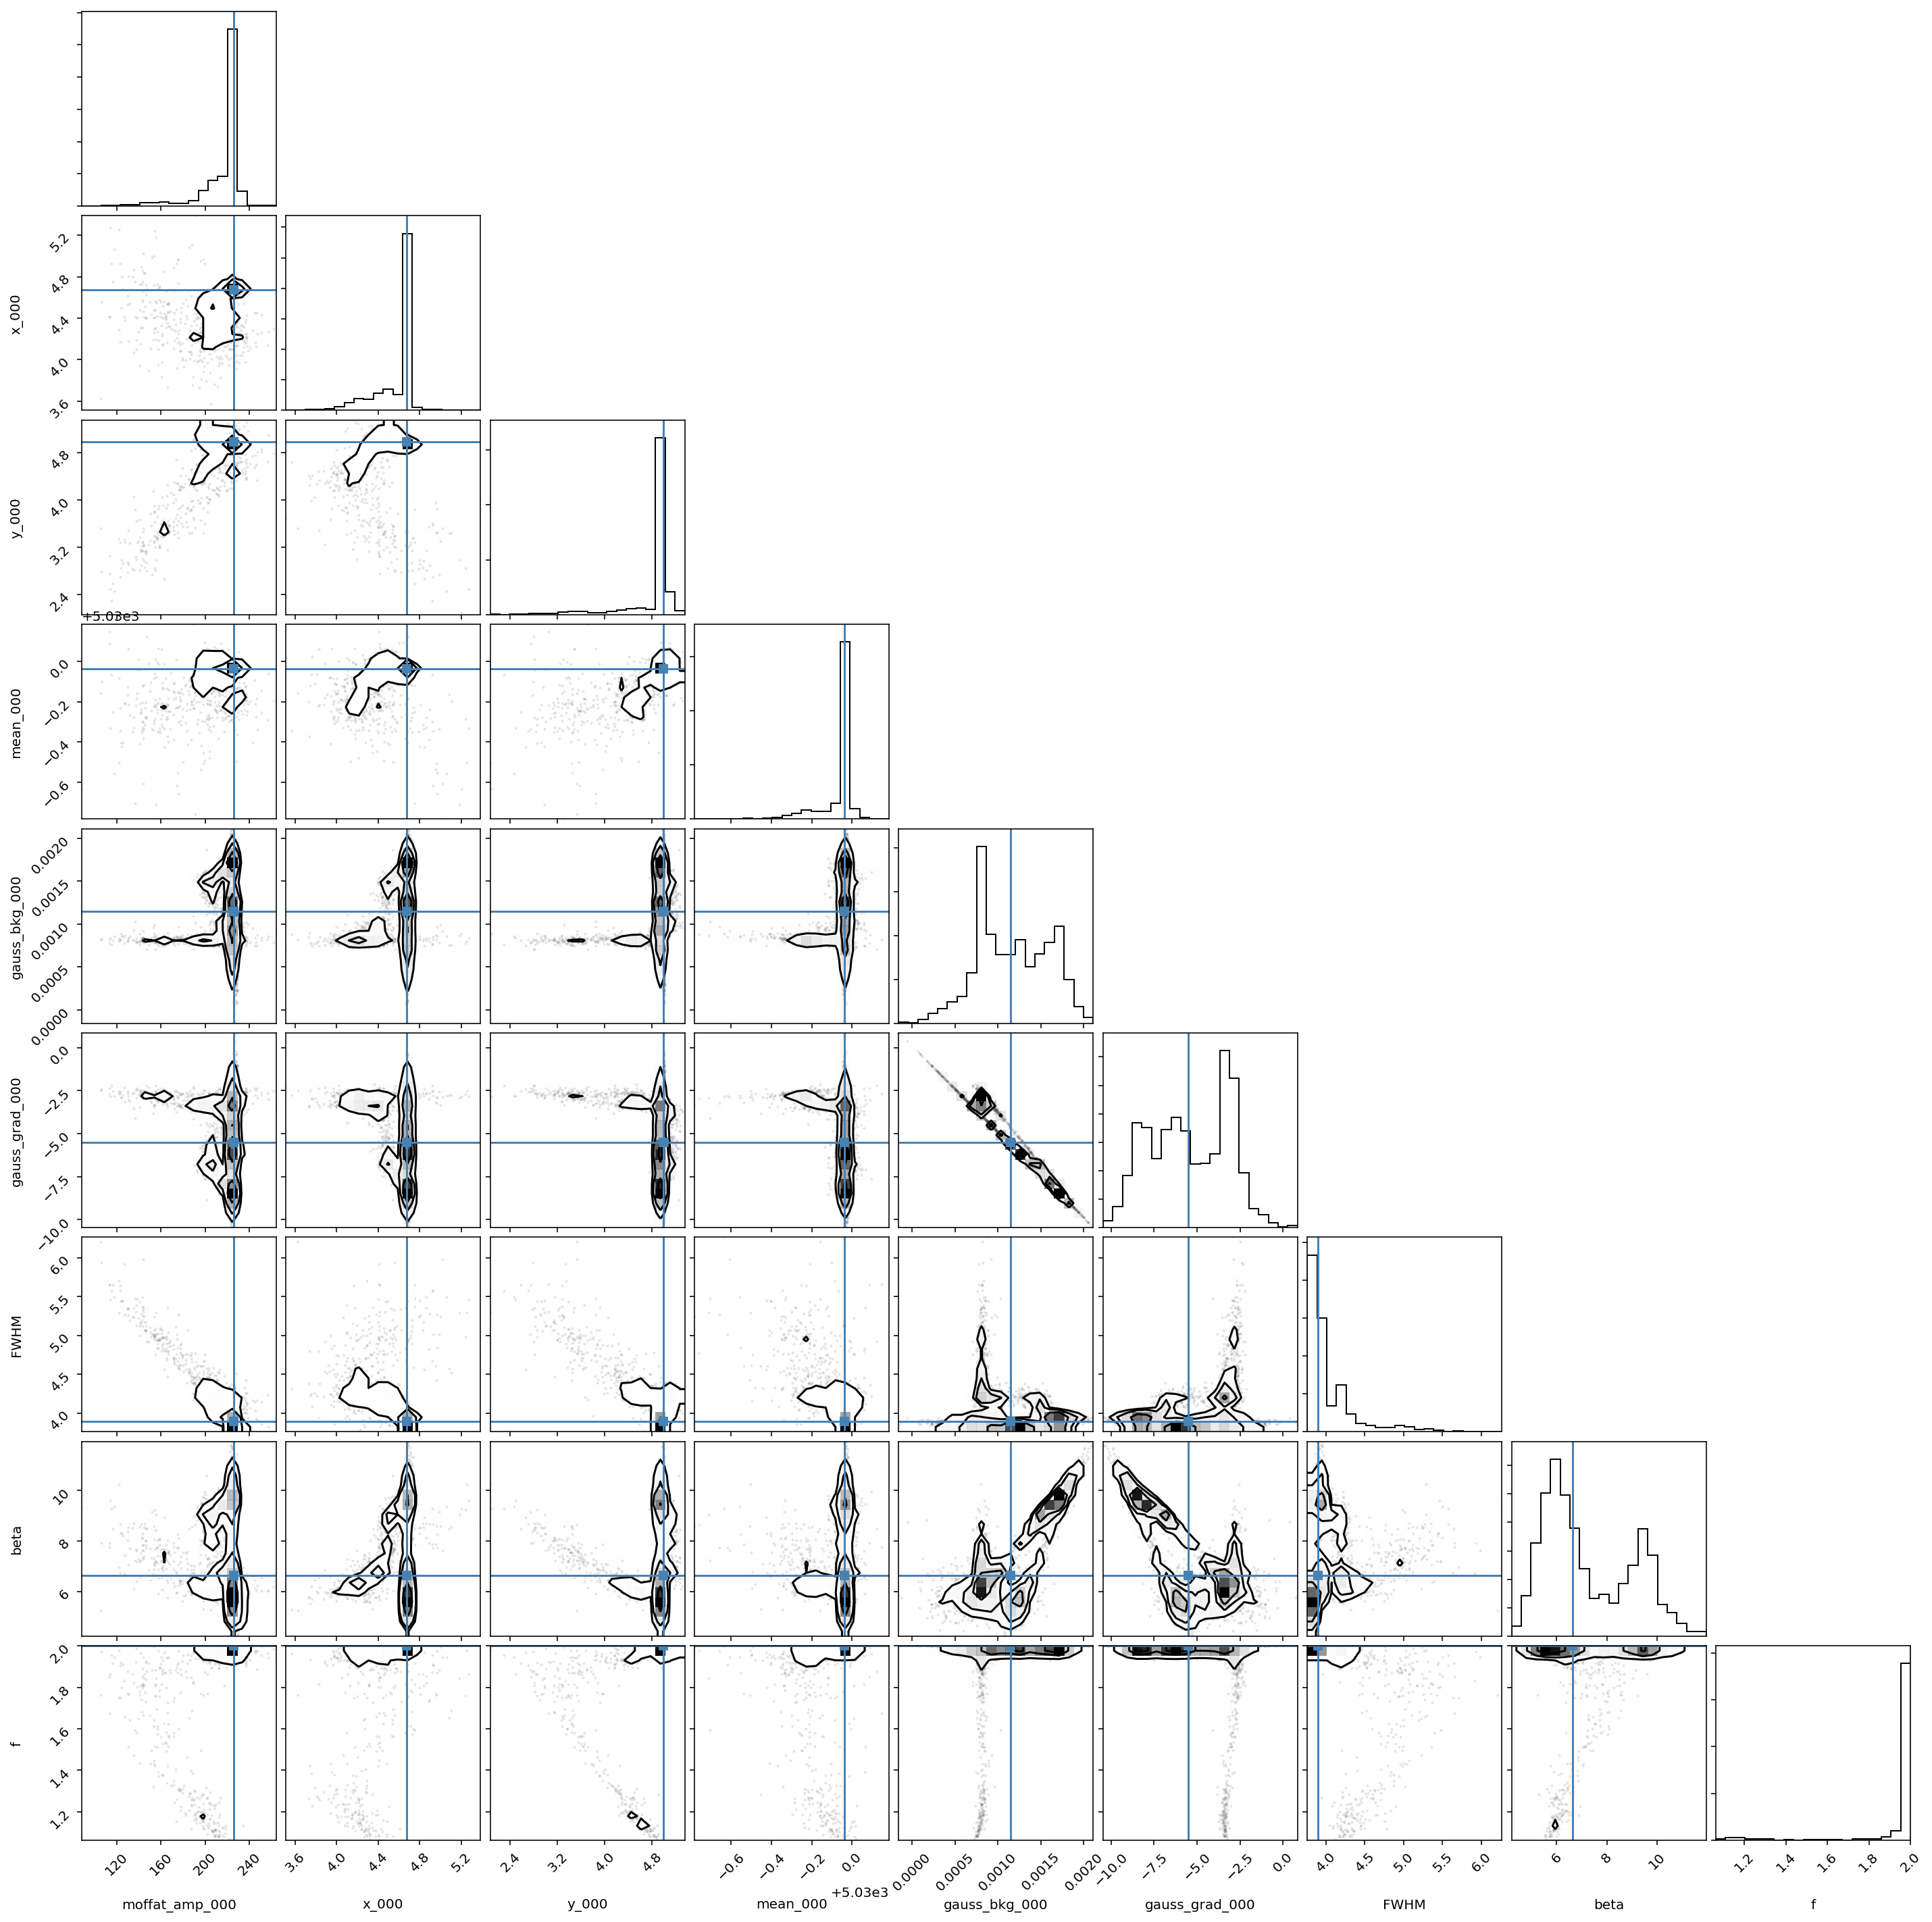

In [5]:
a=corner.corner(MCMC_results.flatchain, labels=MCMC_results.var_names, truths=list(MCMC_results.params.valuesdict().values()))
